In [1]:
import numpy as np 
import torch
from PLNpy.utils import build_block_Sigma, C_from_Sigma, sample_PLN
import matplotlib.pyplot as plt 
import torch.nn as nn 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import seaborn as sns
import torch.nn.functional as F
from PLNpy.utils import log_stirling
import threading

In [2]:
torch.set_printoptions(precision=3)


In [3]:
d = 2
n = 200;  p = 50
q = 5

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else : 
    device = torch.device('cpu')
    
#device = torch.device('cpu') # think I can't use RTX A5000 right now, will check this later. 

torch.cuda.is_available()
#device = torch.device('cpu')

False

In [5]:
device

device(type='cpu')

In [112]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,10))/1 #+ 0.5*torch.eye(p)
#Sigma_sampling = torch.eye(p)

true_C = C_from_Sigma(Sigma_sampling, q)
true_C.to(device)
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p), device = device)/3
covariates = torch.randn((n,d)).to(device)*0
O =  0*torch.randint(2,(n,p)).to(device)
Y, Z, _  = sample_PLN(Sigma_sampling,true_beta, O, covariates)

In [113]:
Y.max()

tensor(848.)

In [13]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VAE(nn.Module):
    def __init__(self, q):
        super().__init__()
        self.q = q 
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, self.q)
        self.z_log_var = torch.nn.Linear(3136, self.q)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(self.q, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
        self.criterion = nn.MSELoss(reduction = 'none')
        self.training_loss_list = list()

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device) 
        z = z_mu# + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded
    
    
    def _train(self,X_train, num_epochs, batch_size, optimizer = torch.optim.Adam, lr = 0.001):
        self.optimizer = optimizer(self.parameters(),
                             lr=lr)
        self.train()
        self.to(device)
        self.bce_loss = nn.BCELoss(reduction = 'sum')
        
        if len(X_train.shape) == 3:
            X_train = X_train.unsqueeze(1)
        self.train()

        for i,epoch in enumerate(range(num_epochs)):
            training_loss = 0 
            cmpt = 0 
            for img in get_batch(X_train, y = None, batch_size = batch_size):
                encoded, z_mean, z_log_var, decoded = self.forward(img)
                
                KL = self.my_loss(z_mean, z_log_var )
                loss = KL + self.bce_loss(decoded, img)
                '''
                kl_div = -0.5 * torch.sum(1 + z_log_var 
                          - z_mean**2 
                          - torch.exp(z_log_var), 
                          axis=1) # sum over latent dimension
                batchsize = kl_div.size(0)
                kl_div = kl_div.mean() # average over batch dimension

                pixelwise = self.criterion(decoded, img)
                pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
                pixelwise = pixelwise.mean() # average over batch dimension
                crit = nn.MSELoss()(decoded, img)
                loss = crit #+ kl_div 
                
                loss = 1*pixelwise + kl_div
                #print('pixelwise crit ', pixelwise)
                '''
                
                #loss = self.criterion(decoded, img)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                training_loss+= loss.item()
                cmpt += 1
            self.training_loss_list.append(training_loss/cmpt)
            print(f'Epoch:{epoch+1}, Training loss:{training_loss/cmpt:.4f}')
        print('Training finished')
        
    def my_loss(self, mu, logvar): 
        return - 1/2* torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
        
        
    def plot_some(self,X,y, nb_toplot = 5): 
        if len(X.shape) == 3:
            X = X.unsqueeze(1)
        _,_,_,output = self.forward(X[:nb_toplot,:,:])
        for i in range(nb_toplot):
            print('y_train ', y[i])
            sns.heatmap(output[i,0,:,:].detach().cpu().numpy())
            plt.show()
            sns.heatmap(X[i,0,:,:].detach().cpu().numpy())
            plt.show()

In [14]:
def plot(model):
    '''
    Plot a model, in most casesa neural network
    It will plot the training loss through epoch, and also the test loss. 
    '''
    train_length = len(model.training_loss_list)
    fig, ax = plt.subplots(2,1)
    ax[0].plot(np.arange(train_length), model.training_loss_list, label = 'Training_loss') 
    ax[0].set_yscale('log')
    try:
        test_length = len(model.test_loss_list)
        ax[1].plot(np.arange(test_length), model.test_loss_list, label = 'Test loss')
    except: 
        print('The model has not been tested, wont plot the test loss') 
    ax[0].legend()
    ax[1].legend()
    
    plt.show()


def get_batch(X,y= None, batch_size = 50):
    '''Get the batches required to do a  minibatch gradient ascent.

    Args:
        X: torch.tensor of size (n, n_features).
        y: torch.tensor. Target, if supervised model, of size n. 
            Default is None (unsupervised model)   
        batch_size: int. The batch size. Should be lower than n. Default is 50
       
    Returns: A generator. Will generate n//batch_size + 1 batches of
        size batch_size (except the last one since the rest of the
        division is not always 0)
    '''
    n = X.shape[0]


    indices = np.arange(n)
    # Shuffle the indices to avoid a regular path.
    np.random.shuffle(indices)
    # Set the batch size of the model to the right size
    # get the number of batches and the size of the last one.
    nb_full_batch, last_batch_size = n // batch_size, n % batch_size
    if y == None: 
        for i in range(nb_full_batch):
            yield X[indices[i * batch_size: (i + 1) * batch_size]]
                   
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            yield X[indices[-last_batch_size:]]
                   
        
    else: 
        if y.shape[0]!= n:
            raise AttributeError('X and y does not have the same shape')
        for i in range(nb_full_batch):
            yield (X[indices[i * batch_size: (i + 1) * batch_size]],
                   y[indices[i *batch_size: (i + 1) * batch_size]],
                   )
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            yield (X[indices[-last_batch_size:]],
                   y[indices[-last_batch_size:]],
                   )
            


In [15]:
class PLN_encoder(nn.Module):
    
    def __init__(self, input_dim, q): 
        super().__init__()        
        self.input_dim = input_dim 
        self.q = q 

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 30), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 12),
            nn.ReLU(),
            #nn.Linear(12, q) # -> N, 3
        )
        
        self.z_mean = torch.nn.Linear(12, self.q)
        self.z_log_var = torch.nn.Linear(12, self.q)
        
        self.decoder = nn.Sequential(
            nn.Linear(q, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            #nn.Sigmoid()
        )
        self.criterion = nn.MSELoss()
        self.training_loss_list = []
        self.test_loss_list = []
        self.min_test_loss = 1e30
        
        
        
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device) 
        z = z_mu# + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        #decoded = self.decoder(encoded)
        return z_mean, z_log_var#, decoded
    
    
    def _train(self,Y,O,covariates, num_epochs, batch_size, 
               optimizer = torch.optim.Adam, model_optimizer = torch.optim.Rprop, 
               lr = 0.001, lr_model = 0.01, verbose = False):
        self.Y = Y
        self.O = O
        self.covariates = covariates
        self.q = q 
        self.d = d
        self.n = n 
        self.p = p
        self.C = torch.randn((self.p, self.q)).to(device)
        self.beta = torch.randn((self.d, self.p)).to(device)
        self.M = torch.randn((self.n, self.q)).to(device)
        self.S = torch.randn((self.n, self.q)).to(device)
        self.model_optimizer = model_optimizer([self.beta, self.C, self.M, self.S], lr = lr_model )
        self.optimizer = optimizer(self.parameters(),lr=lr)
        self.train()
        self.to(device)
        self.mse_loss = nn.MSELoss(reduction = 'sum')
        self.beta.requires_grad_(True)
        self.M.requires_grad_(True)
        self.S.requires_grad_(True)
        self.C.requires_grad_(True)
        

        
        #if len(Y.shape) == 3:
        #    X_train = X_train.unsqueeze(1)
        self.train()

        for i,epoch in enumerate(range(num_epochs)):
            training_loss = 0 
            cmpt = 0 
            for Y_b, O_b, covariates_b, indices in self.get_YOcovbatch(batch_size = batch_size):
                self.Y_b = Y_b 
                self.O_b = O_b
                self.covariates_b = covariates_b
                z_mean, z_log_var = self.forward(Y_b)
                #print('decode, ', decoded.shape)
                KL = self.my_loss(z_mean, z_log_var )
                #loss = KL + self.mse_loss(decoded, img)
                '''
                kl_div = -0.5 * torch.sum(1 + z_log_var 
                          - z_mean**2 
                          - torch.exp(z_log_var), 
                          axis=1) # sum over latent dimension
                batchsize = kl_div.size(0)
                kl_div = kl_div.mean() # average over batch dimension

                pixelwise = self.criterion(decoded, img)
                pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
                pixelwise = pixelwise.mean() # average over batch dimension
                crit = nn.MSELoss()(decoded, img)
                loss = crit #+ kl_div 
                
                loss = 1*pixelwise + kl_div
                #print('pixelwise crit ', pixelwise)
                '''
                simple_var = False
                if simple_var == False : 
                    loss = -self.elbo_loss(z_mean, z_log_var)
                else: 
                    loss = -ELBO_PCA(self.Y,self.O,self.covariates, self.M, self.S, self.C, self.beta)
                    
                #loss = self.criterion(decoded, img)
                self.optimizer.zero_grad()
                self.model_optimizer.zero_grad()
                loss.backward()
                if simple_var == False: 
                    self.optimizer.step()
                self.model_optimizer.step()
                training_loss+= loss.item()
                cmpt += 1
            self.training_loss_list.append(training_loss/(self.n))
            if verbose : 
                print(f'Epoch:{epoch+1}, Training loss:{training_loss/(self.n):.4f}')
            ## Early stopping 
        print('Training finished')
        
    def my_loss(self, mu, logvar): 
        return - 1/2* torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    
    def elbo_loss(self, mu, log_var): 
        return ELBO_PCA(self.Y_b,self.O_b,self.covariates_b, mu, torch.exp(log_var), self.C, self.beta)
    
            
    def get_YOcovbatch(self,batch_size):
        '''Get the batches required to do a  minibatch gradient ascent.

        Args:
            batch_size: int. The batch size. Should be lower than n.

        Returns: A generator. Will generate n//batch_size + 1 batches of
            size batch_size (except the last one since the rest of the
            division is not always 0)
        '''
        indices = np.arange(self.n)
        # Shuffle the indices to avoid a regular path.
        np.random.shuffle(indices)
        # Set the batch size of the model to the right size
        self.batch_size = batch_size
        # get the number of batches and the size of the last one.
        nb_full_batch, last_batch_size = self.n // batch_size, self.n % batch_size
        for i in range(nb_full_batch):
            yield (self.Y[indices[i * batch_size: (i + 1) * batch_size]],
                   self.O[indices[i * batch_size: (i + 1) * batch_size]],
                   self.covariates[indices[i *
                                           batch_size: (i + 1) * batch_size]],
                   indices[i * batch_size: (i + 1) * batch_size]
                   )
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            self.batch_size = last_batch_size
            yield (self.Y[indices[-last_batch_size:]],
                   self.O[indices[-last_batch_size:]],
                   self.covariates[indices[-last_batch_size:]],
                   indices[-last_batch_size:]
                   )

In [31]:
class PLN_VAE(nn.Module):
    
    def __init__(self, input_dim, q): 
        super().__init__()        
        self.input_dim = input_dim 
        self.q = q 

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 40), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 12),
            nn.ReLU(),
            #nn.Linear(12, q) # -> N, 3
        )
        
        self.z_mean = torch.nn.Linear(12, self.q)
        self.z_log_var = torch.nn.Linear(12, self.q)
        
        self.decoder = nn.Sequential(
            nn.Linear(q, 12),
            nn.ReLU(),
            nn.Linear(12, 30),
            nn.ReLU(),
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, input_dim),
            #nn.Sigmoid()
        )
        self.criterion = nn.MSELoss()
        self.training_loss_list = []
        self.test_loss_list = []
        self.min_test_loss = 1e30
        
        
    def recon_loss(self, phiz): 
        return -torch.sum(-torch.exp(self.O_b + phiz) + torch.multiply(phiz + self.O_b,self.Y_b) - log_stirling(self.Y_b))
    
    def KL_loss(self, mu, log_var):
        return -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var))
        
        
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var) # just add a gaussian noise 
        return encoded
        
    def reparameterize(self, mu, log_var):
        eps = torch.randn(mu.size(0), mu.size(1)).to(device) 
        z = mu + eps * torch.exp(log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var) ## add a gaussian noise to the mean and var 
        decoded = self.decoder(encoded)
        return z_mean, z_log_var, decoded
    
    
    def _train(self,Y,O,covariates, num_epochs, batch_size, 
               optimizer = torch.optim.Adam, model_optimizer = torch.optim.Rprop, 
               lr = 0.001, lr_model = 0.01, verbose = False):
        self.Y = Y
        self.O = O
        self.covariates = covariates
        self.q = q 
        self.d = d
        self.n = n 
        self.p = p
        self.C = torch.randn((self.p, self.q)).to(device)
        self.beta = torch.randn((self.d, self.p)).to(device)
        self.M = torch.randn((self.n, self.q)).to(device)
        self.S = torch.randn((self.n, self.q)).to(device)
        self.model_optimizer = model_optimizer([self.beta, self.C, self.M, self.S], lr = lr_model )
        self.optimizer = optimizer(self.parameters(),lr=lr)
        self.train()
        self.to(device)
        self.mse_loss = nn.MSELoss(reduction = 'sum')
        self.beta.requires_grad_(True)
        self.M.requires_grad_(True)
        self.S.requires_grad_(True)
        self.C.requires_grad_(True)
        

        
        #if len(Y.shape) == 3:
        #    X_train = X_train.unsqueeze(1)
        self.train()

        for i,epoch in enumerate(range(num_epochs)):
            training_loss = 0 
            cmpt = 0 
            for Y_b, O_b, covariates_b, indices in self.get_YOcovbatch(batch_size = batch_size):
                self.Y_b = Y_b 
                self.O_b = O_b
                self.covariates_b = covariates_b
                z_mean, z_log_var, decoded = self.forward(Y_b)
                #print('decode, ', decoded.shape)
                KL = self.KL_loss(z_mean, z_log_var)
                recon_loss = self.recon_loss(decoded) 
                loss = KL + recon_loss 
                self.optimizer.zero_grad()
                #self.model_optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                #self.model_optimizer.step()
                training_loss+= loss.item()
                cmpt += 1
            self.training_loss_list.append(training_loss/(self.n))
            if verbose : 
                print(f'Epoch:{epoch+1}, Training loss:{training_loss/(self.n):.4f}')
            ## Early stopping 
        print('Training finished')
        
    
    def elbo_loss(self, mu, log_var): 
        return ELBO_PCA(self.Y_b,self.O_b,self.covariates_b, mu, torch.exp(log_var), self.C, self.beta)
    
            
    def get_YOcovbatch(self,batch_size):
        '''Get the batches required to do a  minibatch gradient ascent.

        Args:
            batch_size: int. The batch size. Should be lower than n.

        Returns: A generator. Will generate n//batch_size + 1 batches of
            size batch_size (except the last one since the rest of the
            division is not always 0)
        '''
        indices = np.arange(self.n)
        # Shuffle the indices to avoid a regular path.
        np.random.shuffle(indices)
        # Set the batch size of the model to the right size
        self.batch_size = batch_size
        # get the number of batches and the size of the last one.
        nb_full_batch, last_batch_size = self.n // batch_size, self.n % batch_size
        for i in range(nb_full_batch):
            yield (self.Y[indices[i * batch_size: (i + 1) * batch_size]],
                   self.O[indices[i * batch_size: (i + 1) * batch_size]],
                   self.covariates[indices[i *
                                           batch_size: (i + 1) * batch_size]],
                   indices[i * batch_size: (i + 1) * batch_size]
                   )
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            self.batch_size = last_batch_size
            yield (self.Y[indices[-last_batch_size:]],
                   self.O[indices[-last_batch_size:]],
                   self.covariates[indices[-last_batch_size:]],
                   indices[-last_batch_size:]
                   )

In [32]:
def ELBO_PCA(Y, O, covariates, M, S, C, beta):
    '''compute the ELBO with a PCA parametrization'''
    n = Y.shape[0]
    q = C.shape[1]
    # Store some variables that will need to be computed twice
    A = O + torch.mm(covariates, beta) + torch.mm(M, C.T)
    SrondS = torch.multiply(S, S)
    # Next, we add the four terms of the ELBO_PCA
    YA = torch.sum(torch.multiply(Y, A))
    moinsexpAplusSrondSCCT = torch.sum(-torch.exp(A + 1 / 2 *
                       torch.mm(SrondS, torch.multiply(C, C).T)))
    moinslogSrondS = 1 / 2 * torch.sum(torch.log(SrondS))
    MMplusSrondS = torch.sum(-1 / 2 * (torch.multiply(M, M) + torch.multiply(S, S)))
    log_stirlingY = torch.sum(log_stirling(Y))

    return YA + moinsexpAplusSrondSCCT + moinslogSrondS + MMplusSrondS - log_stirlingY + n * q / 2

In [114]:
lvae = PLN_VAE(p,q)
lvae._train(Y,O,covariates, 20000, batch_size = 15 ,optimizer = torch.optim.RMSprop, lr = 0.0001, lr_model = 0.001, verbose = True)

Epoch:1, Training loss:428.1015
Epoch:2, Training loss:424.7959
Epoch:3, Training loss:422.3385
Epoch:4, Training loss:421.5743
Epoch:5, Training loss:420.2364
Epoch:6, Training loss:418.3016
Epoch:7, Training loss:417.9289
Epoch:8, Training loss:417.8373
Epoch:9, Training loss:413.7998
Epoch:10, Training loss:413.4413
Epoch:11, Training loss:411.4644
Epoch:12, Training loss:411.2932
Epoch:13, Training loss:409.5109
Epoch:14, Training loss:407.4979
Epoch:15, Training loss:402.2042
Epoch:16, Training loss:402.3125
Epoch:17, Training loss:398.7853
Epoch:18, Training loss:399.6312
Epoch:19, Training loss:397.6745
Epoch:20, Training loss:390.1364
Epoch:21, Training loss:379.1568
Epoch:22, Training loss:375.0334
Epoch:23, Training loss:390.2844
Epoch:24, Training loss:370.7757
Epoch:25, Training loss:381.4081
Epoch:26, Training loss:384.0956
Epoch:27, Training loss:370.8096
Epoch:28, Training loss:364.0372
Epoch:29, Training loss:505.5047
Epoch:30, Training loss:365.3707
Epoch:31, Training 

Epoch:246, Training loss:212.1096
Epoch:247, Training loss:211.3798
Epoch:248, Training loss:210.8484
Epoch:249, Training loss:210.5036
Epoch:250, Training loss:211.3290
Epoch:251, Training loss:210.7356
Epoch:252, Training loss:211.6193
Epoch:253, Training loss:210.6574
Epoch:254, Training loss:210.8654
Epoch:255, Training loss:211.0795
Epoch:256, Training loss:209.8813
Epoch:257, Training loss:209.7234
Epoch:258, Training loss:208.9898
Epoch:259, Training loss:209.0039
Epoch:260, Training loss:209.4664
Epoch:261, Training loss:209.1445
Epoch:262, Training loss:206.9386
Epoch:263, Training loss:208.0387
Epoch:264, Training loss:208.5590
Epoch:265, Training loss:207.6279
Epoch:266, Training loss:207.4524
Epoch:267, Training loss:207.9215
Epoch:268, Training loss:206.9037
Epoch:269, Training loss:207.2539
Epoch:270, Training loss:206.3460
Epoch:271, Training loss:205.3057
Epoch:272, Training loss:205.8719
Epoch:273, Training loss:206.0405
Epoch:274, Training loss:205.0981
Epoch:275, Tra

Epoch:491, Training loss:177.6897
Epoch:492, Training loss:177.7452
Epoch:493, Training loss:178.0995
Epoch:494, Training loss:176.8443
Epoch:495, Training loss:177.3172
Epoch:496, Training loss:176.7881
Epoch:497, Training loss:176.7559
Epoch:498, Training loss:177.3029
Epoch:499, Training loss:177.6012
Epoch:500, Training loss:179.4963
Epoch:501, Training loss:176.8928
Epoch:502, Training loss:177.0752
Epoch:503, Training loss:177.2108
Epoch:504, Training loss:176.8071
Epoch:505, Training loss:176.8360
Epoch:506, Training loss:176.4809
Epoch:507, Training loss:176.7807
Epoch:508, Training loss:176.7465
Epoch:509, Training loss:177.2658
Epoch:510, Training loss:177.4301
Epoch:511, Training loss:177.9072
Epoch:512, Training loss:176.1959
Epoch:513, Training loss:176.3181
Epoch:514, Training loss:175.7657
Epoch:515, Training loss:175.5775
Epoch:516, Training loss:174.8216
Epoch:517, Training loss:175.4761
Epoch:518, Training loss:176.4203
Epoch:519, Training loss:175.6090
Epoch:520, Tra

Epoch:736, Training loss:165.1740
Epoch:737, Training loss:164.4443
Epoch:738, Training loss:164.6052
Epoch:739, Training loss:164.6492
Epoch:740, Training loss:163.6128
Epoch:741, Training loss:163.2972
Epoch:742, Training loss:163.3901
Epoch:743, Training loss:163.4097
Epoch:744, Training loss:164.4736
Epoch:745, Training loss:164.8385
Epoch:746, Training loss:163.5868
Epoch:747, Training loss:164.0876
Epoch:748, Training loss:163.3919
Epoch:749, Training loss:164.0726
Epoch:750, Training loss:163.4456
Epoch:751, Training loss:163.0381
Epoch:752, Training loss:163.1250
Epoch:753, Training loss:163.3026
Epoch:754, Training loss:163.1791
Epoch:755, Training loss:164.0692
Epoch:756, Training loss:166.8775
Epoch:757, Training loss:164.0571
Epoch:758, Training loss:162.4975
Epoch:759, Training loss:162.8547
Epoch:760, Training loss:163.0779
Epoch:761, Training loss:162.5289
Epoch:762, Training loss:162.9907
Epoch:763, Training loss:162.7034
Epoch:764, Training loss:162.7983
Epoch:765, Tra

Epoch:981, Training loss:153.4594
Epoch:982, Training loss:155.8179
Epoch:983, Training loss:152.5535
Epoch:984, Training loss:152.1172
Epoch:985, Training loss:152.6000
Epoch:986, Training loss:153.1367
Epoch:987, Training loss:152.4990
Epoch:988, Training loss:152.5680
Epoch:989, Training loss:152.8163
Epoch:990, Training loss:152.3450
Epoch:991, Training loss:152.2911
Epoch:992, Training loss:152.3566
Epoch:993, Training loss:152.0196
Epoch:994, Training loss:151.6896
Epoch:995, Training loss:152.7004
Epoch:996, Training loss:151.7937
Epoch:997, Training loss:152.9625
Epoch:998, Training loss:155.1063
Epoch:999, Training loss:152.9283
Epoch:1000, Training loss:153.5519
Epoch:1001, Training loss:152.0131
Epoch:1002, Training loss:151.5491
Epoch:1003, Training loss:151.2178
Epoch:1004, Training loss:151.2061
Epoch:1005, Training loss:151.3216
Epoch:1006, Training loss:151.9213
Epoch:1007, Training loss:152.6385
Epoch:1008, Training loss:151.4594
Epoch:1009, Training loss:151.8414
Epoc

Epoch:1219, Training loss:146.1714
Epoch:1220, Training loss:146.0442
Epoch:1221, Training loss:146.1660
Epoch:1222, Training loss:146.3186
Epoch:1223, Training loss:146.0225
Epoch:1224, Training loss:146.3634
Epoch:1225, Training loss:146.2371
Epoch:1226, Training loss:146.1297
Epoch:1227, Training loss:145.5282
Epoch:1228, Training loss:145.9672
Epoch:1229, Training loss:147.0312
Epoch:1230, Training loss:146.5012
Epoch:1231, Training loss:146.6291
Epoch:1232, Training loss:147.0639
Epoch:1233, Training loss:146.8073
Epoch:1234, Training loss:145.3549
Epoch:1235, Training loss:145.4127
Epoch:1236, Training loss:145.4750
Epoch:1237, Training loss:145.2813
Epoch:1238, Training loss:145.5327
Epoch:1239, Training loss:145.9395
Epoch:1240, Training loss:145.7754
Epoch:1241, Training loss:145.4159
Epoch:1242, Training loss:145.6500
Epoch:1243, Training loss:145.3993
Epoch:1244, Training loss:146.6402
Epoch:1245, Training loss:145.5988
Epoch:1246, Training loss:145.4884
Epoch:1247, Training

Epoch:1457, Training loss:140.8587
Epoch:1458, Training loss:141.2395
Epoch:1459, Training loss:141.3669
Epoch:1460, Training loss:142.0982
Epoch:1461, Training loss:141.4170
Epoch:1462, Training loss:141.2112
Epoch:1463, Training loss:141.9277
Epoch:1464, Training loss:142.4662
Epoch:1465, Training loss:141.8343
Epoch:1466, Training loss:141.8305
Epoch:1467, Training loss:141.4398
Epoch:1468, Training loss:141.4292
Epoch:1469, Training loss:141.5441
Epoch:1470, Training loss:141.1897
Epoch:1471, Training loss:141.0712
Epoch:1472, Training loss:141.7623
Epoch:1473, Training loss:141.3022
Epoch:1474, Training loss:141.6903
Epoch:1475, Training loss:141.8898
Epoch:1476, Training loss:140.7048
Epoch:1477, Training loss:140.5357
Epoch:1478, Training loss:141.1491
Epoch:1479, Training loss:141.6901
Epoch:1480, Training loss:141.5945
Epoch:1481, Training loss:143.2367
Epoch:1482, Training loss:141.6240
Epoch:1483, Training loss:142.6414
Epoch:1484, Training loss:141.4703
Epoch:1485, Training

Epoch:1695, Training loss:137.2958
Epoch:1696, Training loss:137.7954
Epoch:1697, Training loss:137.4330
Epoch:1698, Training loss:137.7404
Epoch:1699, Training loss:137.7430
Epoch:1700, Training loss:137.7900
Epoch:1701, Training loss:138.4600
Epoch:1702, Training loss:138.5208
Epoch:1703, Training loss:137.8688
Epoch:1704, Training loss:137.5182
Epoch:1705, Training loss:137.3773
Epoch:1706, Training loss:137.5016
Epoch:1707, Training loss:137.3008
Epoch:1708, Training loss:137.7851
Epoch:1709, Training loss:138.1664
Epoch:1710, Training loss:137.7941
Epoch:1711, Training loss:139.0271
Epoch:1712, Training loss:137.8139
Epoch:1713, Training loss:137.5126
Epoch:1714, Training loss:137.0822
Epoch:1715, Training loss:137.5020
Epoch:1716, Training loss:137.2340
Epoch:1717, Training loss:136.9947
Epoch:1718, Training loss:137.1922
Epoch:1719, Training loss:137.3267
Epoch:1720, Training loss:137.2321
Epoch:1721, Training loss:136.9714
Epoch:1722, Training loss:137.3600
Epoch:1723, Training

Epoch:1934, Training loss:134.4631
Epoch:1935, Training loss:135.7418
Epoch:1936, Training loss:133.7860
Epoch:1937, Training loss:134.8189
Epoch:1938, Training loss:133.7751
Epoch:1939, Training loss:133.7619
Epoch:1940, Training loss:133.6496
Epoch:1941, Training loss:134.3814
Epoch:1942, Training loss:133.6262
Epoch:1943, Training loss:133.9589
Epoch:1944, Training loss:133.7227
Epoch:1945, Training loss:134.6807
Epoch:1946, Training loss:135.2668
Epoch:1947, Training loss:133.8875
Epoch:1948, Training loss:133.1383
Epoch:1949, Training loss:133.6425
Epoch:1950, Training loss:133.7720
Epoch:1951, Training loss:133.1204
Epoch:1952, Training loss:134.0222
Epoch:1953, Training loss:133.9878
Epoch:1954, Training loss:133.5599
Epoch:1955, Training loss:133.2045
Epoch:1956, Training loss:134.0191
Epoch:1957, Training loss:133.7409
Epoch:1958, Training loss:133.5941
Epoch:1959, Training loss:133.5433
Epoch:1960, Training loss:134.2610
Epoch:1961, Training loss:134.0338
Epoch:1962, Training

Epoch:2172, Training loss:130.6143
Epoch:2173, Training loss:130.6894
Epoch:2174, Training loss:131.4111
Epoch:2175, Training loss:131.0312
Epoch:2176, Training loss:130.4520
Epoch:2177, Training loss:130.7287
Epoch:2178, Training loss:130.4497
Epoch:2179, Training loss:130.1940
Epoch:2180, Training loss:130.2424
Epoch:2181, Training loss:130.0875
Epoch:2182, Training loss:130.4678
Epoch:2183, Training loss:131.1000
Epoch:2184, Training loss:130.5707
Epoch:2185, Training loss:130.1421
Epoch:2186, Training loss:130.7166
Epoch:2187, Training loss:130.9402
Epoch:2188, Training loss:130.4334
Epoch:2189, Training loss:129.9146
Epoch:2190, Training loss:130.7368
Epoch:2191, Training loss:130.0507
Epoch:2192, Training loss:130.0761
Epoch:2193, Training loss:129.7958
Epoch:2194, Training loss:129.6451
Epoch:2195, Training loss:130.0016
Epoch:2196, Training loss:129.6998
Epoch:2197, Training loss:130.8289
Epoch:2198, Training loss:130.2921
Epoch:2199, Training loss:131.2873
Epoch:2200, Training

Epoch:2410, Training loss:126.6556
Epoch:2411, Training loss:127.0701
Epoch:2412, Training loss:127.6753
Epoch:2413, Training loss:127.8228
Epoch:2414, Training loss:127.2489
Epoch:2415, Training loss:126.3400
Epoch:2416, Training loss:126.8489
Epoch:2417, Training loss:126.2092
Epoch:2418, Training loss:126.3966
Epoch:2419, Training loss:126.4627
Epoch:2420, Training loss:126.6264
Epoch:2421, Training loss:127.2880
Epoch:2422, Training loss:126.8564
Epoch:2423, Training loss:126.6995
Epoch:2424, Training loss:127.0120
Epoch:2425, Training loss:126.7562
Epoch:2426, Training loss:126.4900
Epoch:2427, Training loss:126.5703
Epoch:2428, Training loss:126.2620
Epoch:2429, Training loss:126.9093
Epoch:2430, Training loss:126.1083
Epoch:2431, Training loss:127.3222
Epoch:2432, Training loss:126.4783
Epoch:2433, Training loss:126.2504
Epoch:2434, Training loss:126.6404
Epoch:2435, Training loss:126.8121
Epoch:2436, Training loss:126.4090
Epoch:2437, Training loss:126.3282
Epoch:2438, Training

Epoch:2648, Training loss:123.3787
Epoch:2649, Training loss:123.6324
Epoch:2650, Training loss:123.7920
Epoch:2651, Training loss:124.1496
Epoch:2652, Training loss:124.1646
Epoch:2653, Training loss:124.2010
Epoch:2654, Training loss:123.9140
Epoch:2655, Training loss:124.3057
Epoch:2656, Training loss:125.9848
Epoch:2657, Training loss:124.4574
Epoch:2658, Training loss:123.5371
Epoch:2659, Training loss:123.3517
Epoch:2660, Training loss:123.4265
Epoch:2661, Training loss:123.1616
Epoch:2662, Training loss:123.7145
Epoch:2663, Training loss:123.0779
Epoch:2664, Training loss:123.4709
Epoch:2665, Training loss:123.5447
Epoch:2666, Training loss:123.7397
Epoch:2667, Training loss:123.2718
Epoch:2668, Training loss:123.0529
Epoch:2669, Training loss:124.0493
Epoch:2670, Training loss:123.2483
Epoch:2671, Training loss:123.8473
Epoch:2672, Training loss:123.5262
Epoch:2673, Training loss:124.7828
Epoch:2674, Training loss:124.0420
Epoch:2675, Training loss:123.7939
Epoch:2676, Training

Epoch:2886, Training loss:122.2136
Epoch:2887, Training loss:121.8028
Epoch:2888, Training loss:120.9790
Epoch:2889, Training loss:120.9114
Epoch:2890, Training loss:121.3861
Epoch:2891, Training loss:121.0668
Epoch:2892, Training loss:121.6959
Epoch:2893, Training loss:121.5375
Epoch:2894, Training loss:121.1951
Epoch:2895, Training loss:121.2560
Epoch:2896, Training loss:121.2651
Epoch:2897, Training loss:120.8385
Epoch:2898, Training loss:121.5205
Epoch:2899, Training loss:121.9918
Epoch:2900, Training loss:122.0353
Epoch:2901, Training loss:121.0242
Epoch:2902, Training loss:121.1942
Epoch:2903, Training loss:121.3343
Epoch:2904, Training loss:120.8705
Epoch:2905, Training loss:121.1293
Epoch:2906, Training loss:121.1160
Epoch:2907, Training loss:120.8914
Epoch:2908, Training loss:120.8062
Epoch:2909, Training loss:121.3280
Epoch:2910, Training loss:120.9888
Epoch:2911, Training loss:121.4493
Epoch:2912, Training loss:122.6443
Epoch:2913, Training loss:121.7886
Epoch:2914, Training

Epoch:3124, Training loss:119.5397
Epoch:3125, Training loss:118.8840
Epoch:3126, Training loss:119.0486
Epoch:3127, Training loss:119.2148
Epoch:3128, Training loss:119.2304
Epoch:3129, Training loss:118.5860
Epoch:3130, Training loss:118.5933
Epoch:3131, Training loss:118.7094
Epoch:3132, Training loss:119.2979
Epoch:3133, Training loss:119.6578
Epoch:3134, Training loss:119.3599
Epoch:3135, Training loss:119.0065
Epoch:3136, Training loss:119.2748
Epoch:3137, Training loss:119.2097
Epoch:3138, Training loss:118.5570
Epoch:3139, Training loss:118.8984
Epoch:3140, Training loss:119.5097
Epoch:3141, Training loss:119.6175
Epoch:3142, Training loss:118.8954
Epoch:3143, Training loss:119.1708
Epoch:3144, Training loss:118.8113
Epoch:3145, Training loss:119.0379
Epoch:3146, Training loss:119.0651
Epoch:3147, Training loss:119.2087
Epoch:3148, Training loss:118.9667
Epoch:3149, Training loss:119.0766
Epoch:3150, Training loss:119.3474
Epoch:3151, Training loss:119.3008
Epoch:3152, Training

Epoch:3362, Training loss:117.2609
Epoch:3363, Training loss:117.4644
Epoch:3364, Training loss:117.4725
Epoch:3365, Training loss:118.2702
Epoch:3366, Training loss:116.8714
Epoch:3367, Training loss:117.5736
Epoch:3368, Training loss:117.1909
Epoch:3369, Training loss:117.1425
Epoch:3370, Training loss:117.4721
Epoch:3371, Training loss:117.6545
Epoch:3372, Training loss:117.3724
Epoch:3373, Training loss:116.7955
Epoch:3374, Training loss:117.7446
Epoch:3375, Training loss:117.6104
Epoch:3376, Training loss:117.3625
Epoch:3377, Training loss:116.7971
Epoch:3378, Training loss:116.6730
Epoch:3379, Training loss:117.1256
Epoch:3380, Training loss:117.1580
Epoch:3381, Training loss:117.4119
Epoch:3382, Training loss:117.4329
Epoch:3383, Training loss:117.0116
Epoch:3384, Training loss:116.9437
Epoch:3385, Training loss:116.6429
Epoch:3386, Training loss:117.6019
Epoch:3387, Training loss:117.0356
Epoch:3388, Training loss:116.8905
Epoch:3389, Training loss:117.2954
Epoch:3390, Training

Epoch:3600, Training loss:116.1296
Epoch:3601, Training loss:115.2783
Epoch:3602, Training loss:116.0086
Epoch:3603, Training loss:115.4077
Epoch:3604, Training loss:115.1958
Epoch:3605, Training loss:115.5609
Epoch:3606, Training loss:115.2496
Epoch:3607, Training loss:115.1814
Epoch:3608, Training loss:115.6179
Epoch:3609, Training loss:115.6026
Epoch:3610, Training loss:116.2130
Epoch:3611, Training loss:116.4937
Epoch:3612, Training loss:115.4634
Epoch:3613, Training loss:114.9922
Epoch:3614, Training loss:115.5011
Epoch:3615, Training loss:115.6794
Epoch:3616, Training loss:115.0403
Epoch:3617, Training loss:115.2038
Epoch:3618, Training loss:115.5415
Epoch:3619, Training loss:115.5562
Epoch:3620, Training loss:115.6046
Epoch:3621, Training loss:115.6291
Epoch:3622, Training loss:114.7829
Epoch:3623, Training loss:114.9897
Epoch:3624, Training loss:115.5496
Epoch:3625, Training loss:115.6900
Epoch:3626, Training loss:116.3141
Epoch:3627, Training loss:115.6820
Epoch:3628, Training

Epoch:3838, Training loss:114.1893
Epoch:3839, Training loss:113.5062
Epoch:3840, Training loss:114.0529
Epoch:3841, Training loss:114.5382
Epoch:3842, Training loss:114.0774
Epoch:3843, Training loss:114.3439
Epoch:3844, Training loss:113.7708
Epoch:3845, Training loss:114.0488
Epoch:3846, Training loss:114.1176
Epoch:3847, Training loss:113.9353
Epoch:3848, Training loss:113.9200
Epoch:3849, Training loss:113.9101
Epoch:3850, Training loss:114.7318
Epoch:3851, Training loss:114.5657
Epoch:3852, Training loss:114.0655
Epoch:3853, Training loss:114.1883
Epoch:3854, Training loss:113.8029
Epoch:3855, Training loss:113.5934
Epoch:3856, Training loss:113.3743
Epoch:3857, Training loss:113.9759
Epoch:3858, Training loss:113.9019
Epoch:3859, Training loss:113.9346
Epoch:3860, Training loss:113.7513
Epoch:3861, Training loss:114.8657
Epoch:3862, Training loss:114.4069
Epoch:3863, Training loss:114.7148
Epoch:3864, Training loss:113.8890
Epoch:3865, Training loss:113.9230
Epoch:3866, Training

Epoch:4076, Training loss:112.8031
Epoch:4077, Training loss:112.4630
Epoch:4078, Training loss:112.2368
Epoch:4079, Training loss:112.7304
Epoch:4080, Training loss:112.9851
Epoch:4081, Training loss:112.8298
Epoch:4082, Training loss:112.5317
Epoch:4083, Training loss:112.5592
Epoch:4084, Training loss:112.9634
Epoch:4085, Training loss:112.6961
Epoch:4086, Training loss:112.2457
Epoch:4087, Training loss:112.8208
Epoch:4088, Training loss:112.6001
Epoch:4089, Training loss:113.2312
Epoch:4090, Training loss:112.4149
Epoch:4091, Training loss:112.5639
Epoch:4092, Training loss:112.6468
Epoch:4093, Training loss:113.0942
Epoch:4094, Training loss:113.1868
Epoch:4095, Training loss:112.4957
Epoch:4096, Training loss:112.0583
Epoch:4097, Training loss:112.2238
Epoch:4098, Training loss:112.0068
Epoch:4099, Training loss:112.5677
Epoch:4100, Training loss:112.6965
Epoch:4101, Training loss:112.3919
Epoch:4102, Training loss:112.8447
Epoch:4103, Training loss:112.3650
Epoch:4104, Training

Epoch:4314, Training loss:111.1282
Epoch:4315, Training loss:111.5196
Epoch:4316, Training loss:111.3052
Epoch:4317, Training loss:111.3006
Epoch:4318, Training loss:110.8780
Epoch:4319, Training loss:111.8052
Epoch:4320, Training loss:111.6816
Epoch:4321, Training loss:110.9295
Epoch:4322, Training loss:111.3931
Epoch:4323, Training loss:111.3151
Epoch:4324, Training loss:111.3142
Epoch:4325, Training loss:111.9041
Epoch:4326, Training loss:111.8756
Epoch:4327, Training loss:112.0179
Epoch:4328, Training loss:111.0949
Epoch:4329, Training loss:111.6038
Epoch:4330, Training loss:110.9517
Epoch:4331, Training loss:111.5813
Epoch:4332, Training loss:111.7812
Epoch:4333, Training loss:111.6329
Epoch:4334, Training loss:111.9702
Epoch:4335, Training loss:111.7927
Epoch:4336, Training loss:111.2588
Epoch:4337, Training loss:111.4395
Epoch:4338, Training loss:111.2351
Epoch:4339, Training loss:111.0481
Epoch:4340, Training loss:111.0342
Epoch:4341, Training loss:111.2861
Epoch:4342, Training

Epoch:4552, Training loss:110.5050
Epoch:4553, Training loss:110.3942
Epoch:4554, Training loss:110.3071
Epoch:4555, Training loss:109.8849
Epoch:4556, Training loss:110.4571
Epoch:4557, Training loss:110.5645
Epoch:4558, Training loss:110.7048
Epoch:4559, Training loss:110.0227
Epoch:4560, Training loss:110.6489
Epoch:4561, Training loss:110.3538
Epoch:4562, Training loss:110.3519
Epoch:4563, Training loss:110.2109
Epoch:4564, Training loss:109.8203
Epoch:4565, Training loss:109.9247
Epoch:4566, Training loss:110.5345
Epoch:4567, Training loss:110.1258
Epoch:4568, Training loss:109.9667
Epoch:4569, Training loss:109.7860
Epoch:4570, Training loss:110.1433
Epoch:4571, Training loss:110.4115
Epoch:4572, Training loss:110.2162
Epoch:4573, Training loss:111.1006
Epoch:4574, Training loss:110.5449
Epoch:4575, Training loss:110.0259
Epoch:4576, Training loss:110.0878
Epoch:4577, Training loss:110.1677
Epoch:4578, Training loss:110.2440
Epoch:4579, Training loss:110.1497
Epoch:4580, Training

Epoch:4790, Training loss:108.9817
Epoch:4791, Training loss:109.0846
Epoch:4792, Training loss:109.5046
Epoch:4793, Training loss:109.1562
Epoch:4794, Training loss:109.6407
Epoch:4795, Training loss:108.9637
Epoch:4796, Training loss:109.2753
Epoch:4797, Training loss:109.8294
Epoch:4798, Training loss:109.2180
Epoch:4799, Training loss:109.8493
Epoch:4800, Training loss:109.8106
Epoch:4801, Training loss:109.5276
Epoch:4802, Training loss:110.0981
Epoch:4803, Training loss:109.4689
Epoch:4804, Training loss:108.8470
Epoch:4805, Training loss:109.2357
Epoch:4806, Training loss:109.0966
Epoch:4807, Training loss:109.5028
Epoch:4808, Training loss:109.0047
Epoch:4809, Training loss:108.8915
Epoch:4810, Training loss:109.2430
Epoch:4811, Training loss:109.1049
Epoch:4812, Training loss:109.2230
Epoch:4813, Training loss:108.8630
Epoch:4814, Training loss:109.3263
Epoch:4815, Training loss:109.3578
Epoch:4816, Training loss:109.2086
Epoch:4817, Training loss:108.6603
Epoch:4818, Training

Epoch:5028, Training loss:107.9454
Epoch:5029, Training loss:108.4502
Epoch:5030, Training loss:107.9363
Epoch:5031, Training loss:108.0158
Epoch:5032, Training loss:108.1296
Epoch:5033, Training loss:108.0725
Epoch:5034, Training loss:108.6699
Epoch:5035, Training loss:107.7932
Epoch:5036, Training loss:108.5639
Epoch:5037, Training loss:108.3626
Epoch:5038, Training loss:108.6963
Epoch:5039, Training loss:108.8582
Epoch:5040, Training loss:108.6142
Epoch:5041, Training loss:107.9945
Epoch:5042, Training loss:107.9708
Epoch:5043, Training loss:108.6145
Epoch:5044, Training loss:108.2479
Epoch:5045, Training loss:108.5885
Epoch:5046, Training loss:108.3101
Epoch:5047, Training loss:109.2748
Epoch:5048, Training loss:108.3873
Epoch:5049, Training loss:107.7922
Epoch:5050, Training loss:108.1239
Epoch:5051, Training loss:107.9906
Epoch:5052, Training loss:108.4814
Epoch:5053, Training loss:108.6346
Epoch:5054, Training loss:108.9336
Epoch:5055, Training loss:108.6692
Epoch:5056, Training

Epoch:5266, Training loss:107.2371
Epoch:5267, Training loss:107.2737
Epoch:5268, Training loss:106.9835
Epoch:5269, Training loss:107.6046
Epoch:5270, Training loss:107.4550
Epoch:5271, Training loss:107.4575
Epoch:5272, Training loss:107.3338
Epoch:5273, Training loss:107.2625
Epoch:5274, Training loss:107.5170
Epoch:5275, Training loss:106.9779
Epoch:5276, Training loss:107.5544
Epoch:5277, Training loss:107.4114
Epoch:5278, Training loss:107.5599
Epoch:5279, Training loss:107.5013
Epoch:5280, Training loss:107.8362
Epoch:5281, Training loss:107.6935
Epoch:5282, Training loss:107.4709
Epoch:5283, Training loss:107.3058
Epoch:5284, Training loss:107.3589
Epoch:5285, Training loss:107.3815
Epoch:5286, Training loss:107.6900
Epoch:5287, Training loss:107.9016
Epoch:5288, Training loss:107.6525
Epoch:5289, Training loss:107.5624
Epoch:5290, Training loss:107.5424
Epoch:5291, Training loss:107.5527
Epoch:5292, Training loss:107.4874
Epoch:5293, Training loss:107.3872
Epoch:5294, Training

Epoch:5504, Training loss:106.8308
Epoch:5505, Training loss:107.3753
Epoch:5506, Training loss:106.4999
Epoch:5507, Training loss:106.7794
Epoch:5508, Training loss:106.3970
Epoch:5509, Training loss:107.0412
Epoch:5510, Training loss:107.1195
Epoch:5511, Training loss:106.5400
Epoch:5512, Training loss:106.4894
Epoch:5513, Training loss:106.9878
Epoch:5514, Training loss:106.5494
Epoch:5515, Training loss:106.3905
Epoch:5516, Training loss:106.1083
Epoch:5517, Training loss:106.4852
Epoch:5518, Training loss:106.7631
Epoch:5519, Training loss:107.3923
Epoch:5520, Training loss:106.7725
Epoch:5521, Training loss:106.6617
Epoch:5522, Training loss:106.3596
Epoch:5523, Training loss:106.5531
Epoch:5524, Training loss:106.7327
Epoch:5525, Training loss:106.9691
Epoch:5526, Training loss:106.5549
Epoch:5527, Training loss:106.2250
Epoch:5528, Training loss:106.4631
Epoch:5529, Training loss:106.2772
Epoch:5530, Training loss:106.9172
Epoch:5531, Training loss:106.5080
Epoch:5532, Training

Epoch:5742, Training loss:105.9470
Epoch:5743, Training loss:106.1897
Epoch:5744, Training loss:105.8463
Epoch:5745, Training loss:105.5668
Epoch:5746, Training loss:105.8500
Epoch:5747, Training loss:105.7191
Epoch:5748, Training loss:106.3378
Epoch:5749, Training loss:105.3552
Epoch:5750, Training loss:105.7354
Epoch:5751, Training loss:106.5882
Epoch:5752, Training loss:106.1303
Epoch:5753, Training loss:105.9504
Epoch:5754, Training loss:105.8177
Epoch:5755, Training loss:105.8856
Epoch:5756, Training loss:105.7246
Epoch:5757, Training loss:105.9004
Epoch:5758, Training loss:105.9874
Epoch:5759, Training loss:105.9697
Epoch:5760, Training loss:105.4778
Epoch:5761, Training loss:105.8299
Epoch:5762, Training loss:106.0530
Epoch:5763, Training loss:106.2145
Epoch:5764, Training loss:105.6806
Epoch:5765, Training loss:105.8843
Epoch:5766, Training loss:105.6742
Epoch:5767, Training loss:106.1152
Epoch:5768, Training loss:105.7095
Epoch:5769, Training loss:105.8526
Epoch:5770, Training

Epoch:5980, Training loss:104.8090
Epoch:5981, Training loss:105.0878
Epoch:5982, Training loss:105.2170
Epoch:5983, Training loss:104.9527
Epoch:5984, Training loss:105.1142
Epoch:5985, Training loss:104.9413
Epoch:5986, Training loss:105.0927
Epoch:5987, Training loss:104.9832
Epoch:5988, Training loss:104.9532
Epoch:5989, Training loss:105.1801
Epoch:5990, Training loss:105.5856
Epoch:5991, Training loss:105.4732
Epoch:5992, Training loss:105.2401
Epoch:5993, Training loss:105.4960
Epoch:5994, Training loss:105.2531
Epoch:5995, Training loss:105.6795
Epoch:5996, Training loss:105.1743
Epoch:5997, Training loss:104.8819
Epoch:5998, Training loss:104.5097
Epoch:5999, Training loss:105.0991
Epoch:6000, Training loss:105.1233
Epoch:6001, Training loss:105.1487
Epoch:6002, Training loss:105.2698
Epoch:6003, Training loss:105.3253
Epoch:6004, Training loss:105.4877
Epoch:6005, Training loss:105.1368
Epoch:6006, Training loss:105.6808
Epoch:6007, Training loss:104.9324
Epoch:6008, Training

Epoch:6218, Training loss:104.6690
Epoch:6219, Training loss:104.5954
Epoch:6220, Training loss:104.3728
Epoch:6221, Training loss:104.5252
Epoch:6222, Training loss:104.6154
Epoch:6223, Training loss:104.7530
Epoch:6224, Training loss:104.4960
Epoch:6225, Training loss:104.4043
Epoch:6226, Training loss:104.9239
Epoch:6227, Training loss:104.1912
Epoch:6228, Training loss:104.1372
Epoch:6229, Training loss:104.4592
Epoch:6230, Training loss:104.2020
Epoch:6231, Training loss:104.4588
Epoch:6232, Training loss:104.5512
Epoch:6233, Training loss:104.6028
Epoch:6234, Training loss:104.7805
Epoch:6235, Training loss:104.3231
Epoch:6236, Training loss:104.6781
Epoch:6237, Training loss:104.1198
Epoch:6238, Training loss:104.9350
Epoch:6239, Training loss:104.8657
Epoch:6240, Training loss:105.0641
Epoch:6241, Training loss:104.5630
Epoch:6242, Training loss:104.4997
Epoch:6243, Training loss:104.9492
Epoch:6244, Training loss:104.3169
Epoch:6245, Training loss:104.2238
Epoch:6246, Training

Epoch:6456, Training loss:104.0069
Epoch:6457, Training loss:103.8475
Epoch:6458, Training loss:104.0200
Epoch:6459, Training loss:104.2693
Epoch:6460, Training loss:103.7227
Epoch:6461, Training loss:103.9385
Epoch:6462, Training loss:103.8932
Epoch:6463, Training loss:104.0066
Epoch:6464, Training loss:104.2462
Epoch:6465, Training loss:104.2108
Epoch:6466, Training loss:103.9282
Epoch:6467, Training loss:104.2462
Epoch:6468, Training loss:104.0919
Epoch:6469, Training loss:103.8026
Epoch:6470, Training loss:103.9003
Epoch:6471, Training loss:103.4903
Epoch:6472, Training loss:104.4892
Epoch:6473, Training loss:103.7670
Epoch:6474, Training loss:103.8815
Epoch:6475, Training loss:103.7421
Epoch:6476, Training loss:103.9706
Epoch:6477, Training loss:103.5223
Epoch:6478, Training loss:103.8864
Epoch:6479, Training loss:103.7952
Epoch:6480, Training loss:104.0038
Epoch:6481, Training loss:103.7613
Epoch:6482, Training loss:104.0003
Epoch:6483, Training loss:103.9415
Epoch:6484, Training

Epoch:6694, Training loss:103.8092
Epoch:6695, Training loss:103.3519
Epoch:6696, Training loss:103.1077
Epoch:6697, Training loss:103.3044
Epoch:6698, Training loss:103.1701
Epoch:6699, Training loss:102.8533
Epoch:6700, Training loss:102.9897
Epoch:6701, Training loss:103.2462
Epoch:6702, Training loss:103.0128
Epoch:6703, Training loss:103.0939
Epoch:6704, Training loss:103.6197
Epoch:6705, Training loss:103.1320
Epoch:6706, Training loss:103.1108
Epoch:6707, Training loss:103.0366
Epoch:6708, Training loss:103.3161
Epoch:6709, Training loss:103.1690
Epoch:6710, Training loss:103.2120
Epoch:6711, Training loss:103.3090
Epoch:6712, Training loss:102.7982
Epoch:6713, Training loss:103.3017
Epoch:6714, Training loss:102.7116
Epoch:6715, Training loss:103.1173
Epoch:6716, Training loss:103.5444
Epoch:6717, Training loss:103.0572
Epoch:6718, Training loss:103.5087
Epoch:6719, Training loss:103.1837
Epoch:6720, Training loss:102.6492
Epoch:6721, Training loss:103.5452
Epoch:6722, Training

Epoch:6932, Training loss:103.1418
Epoch:6933, Training loss:102.5964
Epoch:6934, Training loss:103.5385
Epoch:6935, Training loss:102.7346
Epoch:6936, Training loss:102.6624
Epoch:6937, Training loss:102.8849
Epoch:6938, Training loss:102.8604
Epoch:6939, Training loss:102.7525
Epoch:6940, Training loss:102.2797
Epoch:6941, Training loss:102.6889
Epoch:6942, Training loss:102.7504
Epoch:6943, Training loss:102.9592
Epoch:6944, Training loss:102.6185
Epoch:6945, Training loss:102.7102
Epoch:6946, Training loss:102.9978
Epoch:6947, Training loss:102.5596
Epoch:6948, Training loss:102.1936
Epoch:6949, Training loss:102.2503
Epoch:6950, Training loss:102.9315
Epoch:6951, Training loss:102.4775
Epoch:6952, Training loss:102.6449
Epoch:6953, Training loss:103.0690
Epoch:6954, Training loss:102.7872
Epoch:6955, Training loss:102.7214
Epoch:6956, Training loss:102.3490
Epoch:6957, Training loss:103.1718
Epoch:6958, Training loss:102.6095
Epoch:6959, Training loss:102.9481
Epoch:6960, Training

Epoch:7170, Training loss:103.0868
Epoch:7171, Training loss:102.8784
Epoch:7172, Training loss:102.1010
Epoch:7173, Training loss:102.3010
Epoch:7174, Training loss:101.8362
Epoch:7175, Training loss:102.2136
Epoch:7176, Training loss:102.4052
Epoch:7177, Training loss:102.3505
Epoch:7178, Training loss:102.2945
Epoch:7179, Training loss:103.1753
Epoch:7180, Training loss:102.1816
Epoch:7181, Training loss:102.2088
Epoch:7182, Training loss:101.8847
Epoch:7183, Training loss:102.3169
Epoch:7184, Training loss:101.9272
Epoch:7185, Training loss:102.0128
Epoch:7186, Training loss:102.1822
Epoch:7187, Training loss:102.1097
Epoch:7188, Training loss:102.1520
Epoch:7189, Training loss:101.7104
Epoch:7190, Training loss:102.3169
Epoch:7191, Training loss:102.0095
Epoch:7192, Training loss:102.4641
Epoch:7193, Training loss:102.5911
Epoch:7194, Training loss:102.5441
Epoch:7195, Training loss:101.9042
Epoch:7196, Training loss:102.0500
Epoch:7197, Training loss:101.9715
Epoch:7198, Training

Epoch:7408, Training loss:101.5549
Epoch:7409, Training loss:101.4479
Epoch:7410, Training loss:101.4522
Epoch:7411, Training loss:101.6125
Epoch:7412, Training loss:101.6618
Epoch:7413, Training loss:101.7077
Epoch:7414, Training loss:102.1436
Epoch:7415, Training loss:101.4630
Epoch:7416, Training loss:101.2819
Epoch:7417, Training loss:101.5819
Epoch:7418, Training loss:102.4864
Epoch:7419, Training loss:101.6217
Epoch:7420, Training loss:101.7844
Epoch:7421, Training loss:101.7634
Epoch:7422, Training loss:101.4962
Epoch:7423, Training loss:101.7530
Epoch:7424, Training loss:101.9071
Epoch:7425, Training loss:101.6046
Epoch:7426, Training loss:102.4031
Epoch:7427, Training loss:102.2040
Epoch:7428, Training loss:101.9653
Epoch:7429, Training loss:101.7086
Epoch:7430, Training loss:101.4574
Epoch:7431, Training loss:101.8342
Epoch:7432, Training loss:101.6495
Epoch:7433, Training loss:101.2618
Epoch:7434, Training loss:101.7110
Epoch:7435, Training loss:101.7486
Epoch:7436, Training

Epoch:7646, Training loss:100.9362
Epoch:7647, Training loss:101.4150
Epoch:7648, Training loss:101.3605
Epoch:7649, Training loss:100.9929
Epoch:7650, Training loss:101.3145
Epoch:7651, Training loss:101.3854
Epoch:7652, Training loss:100.8538
Epoch:7653, Training loss:100.8889
Epoch:7654, Training loss:100.9085
Epoch:7655, Training loss:101.6076
Epoch:7656, Training loss:101.1632
Epoch:7657, Training loss:100.9778
Epoch:7658, Training loss:101.1195
Epoch:7659, Training loss:100.7478
Epoch:7660, Training loss:100.7194
Epoch:7661, Training loss:101.0844
Epoch:7662, Training loss:101.0072
Epoch:7663, Training loss:101.3690
Epoch:7664, Training loss:101.4179
Epoch:7665, Training loss:101.0957
Epoch:7666, Training loss:101.0235
Epoch:7667, Training loss:100.9261
Epoch:7668, Training loss:101.4656
Epoch:7669, Training loss:101.2812
Epoch:7670, Training loss:101.4162
Epoch:7671, Training loss:100.9509
Epoch:7672, Training loss:101.1911
Epoch:7673, Training loss:100.8169
Epoch:7674, Training

Epoch:7884, Training loss:100.8407
Epoch:7885, Training loss:100.2531
Epoch:7886, Training loss:101.5419
Epoch:7887, Training loss:101.1567
Epoch:7888, Training loss:101.1741
Epoch:7889, Training loss:100.7262
Epoch:7890, Training loss:100.6957
Epoch:7891, Training loss:100.9301
Epoch:7892, Training loss:101.0568
Epoch:7893, Training loss:101.2102
Epoch:7894, Training loss:100.6736
Epoch:7895, Training loss:100.4882
Epoch:7896, Training loss:100.6345
Epoch:7897, Training loss:100.4657
Epoch:7898, Training loss:100.2726
Epoch:7899, Training loss:100.4682
Epoch:7900, Training loss:100.6626
Epoch:7901, Training loss:100.4862
Epoch:7902, Training loss:100.5170
Epoch:7903, Training loss:101.3640
Epoch:7904, Training loss:100.8980
Epoch:7905, Training loss:100.2305
Epoch:7906, Training loss:100.8541
Epoch:7907, Training loss:100.6257
Epoch:7908, Training loss:100.7794
Epoch:7909, Training loss:100.7723
Epoch:7910, Training loss:100.5963
Epoch:7911, Training loss:100.5949
Epoch:7912, Training

Epoch:8122, Training loss:100.1929
Epoch:8123, Training loss:100.1398
Epoch:8124, Training loss:100.1090
Epoch:8125, Training loss:99.8482
Epoch:8126, Training loss:100.3746
Epoch:8127, Training loss:101.0298
Epoch:8128, Training loss:100.7399
Epoch:8129, Training loss:100.3109
Epoch:8130, Training loss:100.3415
Epoch:8131, Training loss:99.9960
Epoch:8132, Training loss:100.0495
Epoch:8133, Training loss:100.0022
Epoch:8134, Training loss:100.1786
Epoch:8135, Training loss:100.3743
Epoch:8136, Training loss:100.2054
Epoch:8137, Training loss:100.7761
Epoch:8138, Training loss:100.1734
Epoch:8139, Training loss:100.5978
Epoch:8140, Training loss:100.0928
Epoch:8141, Training loss:100.5461
Epoch:8142, Training loss:100.0159
Epoch:8143, Training loss:100.3302
Epoch:8144, Training loss:100.2708
Epoch:8145, Training loss:100.0279
Epoch:8146, Training loss:100.1523
Epoch:8147, Training loss:100.4159
Epoch:8148, Training loss:100.3819
Epoch:8149, Training loss:100.7007
Epoch:8150, Training l

Epoch:8360, Training loss:99.5265
Epoch:8361, Training loss:99.5906
Epoch:8362, Training loss:99.5297
Epoch:8363, Training loss:99.9865
Epoch:8364, Training loss:100.3546
Epoch:8365, Training loss:100.5489
Epoch:8366, Training loss:99.7923
Epoch:8367, Training loss:99.8677
Epoch:8368, Training loss:100.2440
Epoch:8369, Training loss:99.7639
Epoch:8370, Training loss:100.0692
Epoch:8371, Training loss:99.7110
Epoch:8372, Training loss:99.8630
Epoch:8373, Training loss:99.7296
Epoch:8374, Training loss:100.4664
Epoch:8375, Training loss:100.2955
Epoch:8376, Training loss:99.7829
Epoch:8377, Training loss:100.0921
Epoch:8378, Training loss:100.0311
Epoch:8379, Training loss:99.9127
Epoch:8380, Training loss:100.0607
Epoch:8381, Training loss:99.8470
Epoch:8382, Training loss:99.7950
Epoch:8383, Training loss:99.8882
Epoch:8384, Training loss:99.8502
Epoch:8385, Training loss:99.9470
Epoch:8386, Training loss:100.1509
Epoch:8387, Training loss:99.6399
Epoch:8388, Training loss:99.7991
Epoc

Epoch:8605, Training loss:99.7276
Epoch:8606, Training loss:99.3026
Epoch:8607, Training loss:99.6263
Epoch:8608, Training loss:99.1312
Epoch:8609, Training loss:99.6805
Epoch:8610, Training loss:99.7173
Epoch:8611, Training loss:99.1347
Epoch:8612, Training loss:99.3579
Epoch:8613, Training loss:99.3608
Epoch:8614, Training loss:99.5195
Epoch:8615, Training loss:99.5020
Epoch:8616, Training loss:100.1130
Epoch:8617, Training loss:100.8532
Epoch:8618, Training loss:99.4448
Epoch:8619, Training loss:99.4485
Epoch:8620, Training loss:99.4644
Epoch:8621, Training loss:99.3505
Epoch:8622, Training loss:99.5366
Epoch:8623, Training loss:99.3202
Epoch:8624, Training loss:99.8742
Epoch:8625, Training loss:99.4900
Epoch:8626, Training loss:99.5571
Epoch:8627, Training loss:99.7699
Epoch:8628, Training loss:99.6059
Epoch:8629, Training loss:99.4449
Epoch:8630, Training loss:99.6554
Epoch:8631, Training loss:99.4795
Epoch:8632, Training loss:99.2156
Epoch:8633, Training loss:99.0814
Epoch:8634, 

Epoch:8850, Training loss:98.8308
Epoch:8851, Training loss:99.0965
Epoch:8852, Training loss:99.1343
Epoch:8853, Training loss:99.3284
Epoch:8854, Training loss:99.1652
Epoch:8855, Training loss:99.1409
Epoch:8856, Training loss:98.9879
Epoch:8857, Training loss:98.8485
Epoch:8858, Training loss:99.0372
Epoch:8859, Training loss:99.1163
Epoch:8860, Training loss:99.7011
Epoch:8861, Training loss:99.0373
Epoch:8862, Training loss:99.0841
Epoch:8863, Training loss:99.3632
Epoch:8864, Training loss:99.0739
Epoch:8865, Training loss:98.9421
Epoch:8866, Training loss:99.4317
Epoch:8867, Training loss:99.1869
Epoch:8868, Training loss:99.1799
Epoch:8869, Training loss:99.3660
Epoch:8870, Training loss:99.0053
Epoch:8871, Training loss:98.8328
Epoch:8872, Training loss:99.1562
Epoch:8873, Training loss:99.0474
Epoch:8874, Training loss:99.1361
Epoch:8875, Training loss:99.3174
Epoch:8876, Training loss:98.6416
Epoch:8877, Training loss:98.9263
Epoch:8878, Training loss:98.9755
Epoch:8879, Tr

Epoch:9095, Training loss:98.6341
Epoch:9096, Training loss:98.2625
Epoch:9097, Training loss:98.9428
Epoch:9098, Training loss:98.4325
Epoch:9099, Training loss:98.6412
Epoch:9100, Training loss:98.5025
Epoch:9101, Training loss:98.7666
Epoch:9102, Training loss:98.6588
Epoch:9103, Training loss:98.5638
Epoch:9104, Training loss:98.7950
Epoch:9105, Training loss:98.8849
Epoch:9106, Training loss:98.4929
Epoch:9107, Training loss:98.5198
Epoch:9108, Training loss:98.6964
Epoch:9109, Training loss:98.6933
Epoch:9110, Training loss:98.9915
Epoch:9111, Training loss:98.6976
Epoch:9112, Training loss:98.3806
Epoch:9113, Training loss:98.6565
Epoch:9114, Training loss:99.2677
Epoch:9115, Training loss:98.9321
Epoch:9116, Training loss:98.4789
Epoch:9117, Training loss:98.4953
Epoch:9118, Training loss:98.2826
Epoch:9119, Training loss:98.5088
Epoch:9120, Training loss:98.4932
Epoch:9121, Training loss:98.6516
Epoch:9122, Training loss:98.2738
Epoch:9123, Training loss:98.5093
Epoch:9124, Tr

Epoch:9340, Training loss:98.6950
Epoch:9341, Training loss:98.8603
Epoch:9342, Training loss:98.5829
Epoch:9343, Training loss:98.0465
Epoch:9344, Training loss:98.0422
Epoch:9345, Training loss:97.9364
Epoch:9346, Training loss:98.3909
Epoch:9347, Training loss:98.6088
Epoch:9348, Training loss:98.3608
Epoch:9349, Training loss:98.3271
Epoch:9350, Training loss:98.1561
Epoch:9351, Training loss:98.4764
Epoch:9352, Training loss:98.7588
Epoch:9353, Training loss:98.4469
Epoch:9354, Training loss:98.2771
Epoch:9355, Training loss:97.7812
Epoch:9356, Training loss:98.0124
Epoch:9357, Training loss:99.2550
Epoch:9358, Training loss:98.7139
Epoch:9359, Training loss:98.5592
Epoch:9360, Training loss:98.4430
Epoch:9361, Training loss:98.0515
Epoch:9362, Training loss:98.0074
Epoch:9363, Training loss:98.0574
Epoch:9364, Training loss:98.5408
Epoch:9365, Training loss:98.2967
Epoch:9366, Training loss:97.8566
Epoch:9367, Training loss:98.3059
Epoch:9368, Training loss:98.1187
Epoch:9369, Tr

Epoch:9585, Training loss:97.9783
Epoch:9586, Training loss:97.8334
Epoch:9587, Training loss:97.7951
Epoch:9588, Training loss:98.1133
Epoch:9589, Training loss:97.9519
Epoch:9590, Training loss:97.8921
Epoch:9591, Training loss:98.3698
Epoch:9592, Training loss:97.9054
Epoch:9593, Training loss:98.0016
Epoch:9594, Training loss:97.8438
Epoch:9595, Training loss:98.5461
Epoch:9596, Training loss:97.9744
Epoch:9597, Training loss:97.5766
Epoch:9598, Training loss:97.7646
Epoch:9599, Training loss:97.8584
Epoch:9600, Training loss:97.7883
Epoch:9601, Training loss:97.6253
Epoch:9602, Training loss:98.0955
Epoch:9603, Training loss:98.7144
Epoch:9604, Training loss:98.1779
Epoch:9605, Training loss:97.8487
Epoch:9606, Training loss:97.7235
Epoch:9607, Training loss:97.8345
Epoch:9608, Training loss:98.4337
Epoch:9609, Training loss:97.7622
Epoch:9610, Training loss:97.9966
Epoch:9611, Training loss:97.9109
Epoch:9612, Training loss:98.0191
Epoch:9613, Training loss:97.8556
Epoch:9614, Tr

Epoch:9830, Training loss:97.5901
Epoch:9831, Training loss:97.6711
Epoch:9832, Training loss:97.8673
Epoch:9833, Training loss:97.9172
Epoch:9834, Training loss:98.5515
Epoch:9835, Training loss:97.7027
Epoch:9836, Training loss:98.0961
Epoch:9837, Training loss:98.0466
Epoch:9838, Training loss:97.4378
Epoch:9839, Training loss:97.4640
Epoch:9840, Training loss:97.4660
Epoch:9841, Training loss:97.8131
Epoch:9842, Training loss:97.6254
Epoch:9843, Training loss:97.5523
Epoch:9844, Training loss:97.7880
Epoch:9845, Training loss:97.4294
Epoch:9846, Training loss:97.4275
Epoch:9847, Training loss:97.6272
Epoch:9848, Training loss:98.2453
Epoch:9849, Training loss:97.3675
Epoch:9850, Training loss:97.6190
Epoch:9851, Training loss:97.5904
Epoch:9852, Training loss:97.9166
Epoch:9853, Training loss:97.8720
Epoch:9854, Training loss:97.8337
Epoch:9855, Training loss:97.4349
Epoch:9856, Training loss:97.6088
Epoch:9857, Training loss:97.3237
Epoch:9858, Training loss:97.3782
Epoch:9859, Tr

Epoch:10074, Training loss:97.6907
Epoch:10075, Training loss:97.0001
Epoch:10076, Training loss:97.2268
Epoch:10077, Training loss:97.2276
Epoch:10078, Training loss:97.1088
Epoch:10079, Training loss:97.4310
Epoch:10080, Training loss:97.5438
Epoch:10081, Training loss:97.2607
Epoch:10082, Training loss:97.0375
Epoch:10083, Training loss:97.6783
Epoch:10084, Training loss:96.8909
Epoch:10085, Training loss:97.1671
Epoch:10086, Training loss:97.4751
Epoch:10087, Training loss:97.1201
Epoch:10088, Training loss:96.8711
Epoch:10089, Training loss:97.3711
Epoch:10090, Training loss:97.2736
Epoch:10091, Training loss:97.1820
Epoch:10092, Training loss:97.6015
Epoch:10093, Training loss:97.0149
Epoch:10094, Training loss:96.9066
Epoch:10095, Training loss:97.6097
Epoch:10096, Training loss:96.9487
Epoch:10097, Training loss:97.2880
Epoch:10098, Training loss:97.2024
Epoch:10099, Training loss:97.2307
Epoch:10100, Training loss:97.4674
Epoch:10101, Training loss:97.5055
Epoch:10102, Trainin

Epoch:10312, Training loss:97.6258
Epoch:10313, Training loss:96.9382
Epoch:10314, Training loss:97.2056
Epoch:10315, Training loss:97.2583
Epoch:10316, Training loss:96.9097
Epoch:10317, Training loss:97.3747
Epoch:10318, Training loss:96.3803
Epoch:10319, Training loss:96.5635
Epoch:10320, Training loss:96.8518
Epoch:10321, Training loss:97.0233
Epoch:10322, Training loss:96.8967
Epoch:10323, Training loss:96.8307
Epoch:10324, Training loss:98.0001
Epoch:10325, Training loss:97.9782
Epoch:10326, Training loss:97.5459
Epoch:10327, Training loss:96.8101
Epoch:10328, Training loss:96.5868
Epoch:10329, Training loss:96.6385
Epoch:10330, Training loss:96.9879
Epoch:10331, Training loss:96.4710
Epoch:10332, Training loss:97.0220
Epoch:10333, Training loss:97.0113
Epoch:10334, Training loss:97.0338
Epoch:10335, Training loss:96.8186
Epoch:10336, Training loss:97.1783
Epoch:10337, Training loss:97.2293
Epoch:10338, Training loss:96.9896
Epoch:10339, Training loss:97.0434
Epoch:10340, Trainin

Epoch:10550, Training loss:96.3013
Epoch:10551, Training loss:96.8295
Epoch:10552, Training loss:97.1376
Epoch:10553, Training loss:96.5486
Epoch:10554, Training loss:96.7046
Epoch:10555, Training loss:96.3232
Epoch:10556, Training loss:96.5367
Epoch:10557, Training loss:96.9266
Epoch:10558, Training loss:96.5458
Epoch:10559, Training loss:96.5935
Epoch:10560, Training loss:96.7922
Epoch:10561, Training loss:96.5556
Epoch:10562, Training loss:96.8240
Epoch:10563, Training loss:96.5185
Epoch:10564, Training loss:96.7291
Epoch:10565, Training loss:96.3995
Epoch:10566, Training loss:96.3681
Epoch:10567, Training loss:96.5230
Epoch:10568, Training loss:96.7601
Epoch:10569, Training loss:96.5578
Epoch:10570, Training loss:96.5019
Epoch:10571, Training loss:96.6246
Epoch:10572, Training loss:96.9885
Epoch:10573, Training loss:96.6013
Epoch:10574, Training loss:96.5151
Epoch:10575, Training loss:96.4057
Epoch:10576, Training loss:96.5456
Epoch:10577, Training loss:96.5734
Epoch:10578, Trainin

Epoch:10788, Training loss:96.0648
Epoch:10789, Training loss:96.9646
Epoch:10790, Training loss:96.2644
Epoch:10791, Training loss:96.7361
Epoch:10792, Training loss:96.4122
Epoch:10793, Training loss:97.3276
Epoch:10794, Training loss:96.6060
Epoch:10795, Training loss:96.2944
Epoch:10796, Training loss:96.2920
Epoch:10797, Training loss:96.2684
Epoch:10798, Training loss:96.2955
Epoch:10799, Training loss:95.9304
Epoch:10800, Training loss:96.0492
Epoch:10801, Training loss:96.1767
Epoch:10802, Training loss:96.0197
Epoch:10803, Training loss:96.1178
Epoch:10804, Training loss:96.2672
Epoch:10805, Training loss:96.6173
Epoch:10806, Training loss:96.2097
Epoch:10807, Training loss:95.9011
Epoch:10808, Training loss:96.0657
Epoch:10809, Training loss:96.3965
Epoch:10810, Training loss:96.6386
Epoch:10811, Training loss:96.9549
Epoch:10812, Training loss:96.4584
Epoch:10813, Training loss:96.6961
Epoch:10814, Training loss:96.5045
Epoch:10815, Training loss:96.5348
Epoch:10816, Trainin

Epoch:11026, Training loss:96.2770
Epoch:11027, Training loss:96.2557
Epoch:11028, Training loss:95.6796
Epoch:11029, Training loss:96.2701
Epoch:11030, Training loss:96.1504
Epoch:11031, Training loss:96.5612
Epoch:11032, Training loss:96.2807
Epoch:11033, Training loss:96.2382
Epoch:11034, Training loss:95.7215
Epoch:11035, Training loss:96.3555
Epoch:11036, Training loss:96.1419
Epoch:11037, Training loss:95.9634
Epoch:11038, Training loss:96.0006
Epoch:11039, Training loss:95.6102
Epoch:11040, Training loss:96.2118
Epoch:11041, Training loss:95.8005
Epoch:11042, Training loss:95.8134
Epoch:11043, Training loss:96.7128
Epoch:11044, Training loss:96.3115
Epoch:11045, Training loss:96.1261
Epoch:11046, Training loss:96.6369
Epoch:11047, Training loss:96.2803
Epoch:11048, Training loss:96.2925
Epoch:11049, Training loss:96.7489
Epoch:11050, Training loss:96.1853
Epoch:11051, Training loss:96.3022
Epoch:11052, Training loss:96.0309
Epoch:11053, Training loss:95.9457
Epoch:11054, Trainin

Epoch:11264, Training loss:96.3175
Epoch:11265, Training loss:95.7191
Epoch:11266, Training loss:95.8885
Epoch:11267, Training loss:95.7280
Epoch:11268, Training loss:95.9743
Epoch:11269, Training loss:95.9261
Epoch:11270, Training loss:95.8297
Epoch:11271, Training loss:95.7113
Epoch:11272, Training loss:96.1695
Epoch:11273, Training loss:95.6071
Epoch:11274, Training loss:95.5099
Epoch:11275, Training loss:95.8610
Epoch:11276, Training loss:95.7964
Epoch:11277, Training loss:96.5574
Epoch:11278, Training loss:96.1857
Epoch:11279, Training loss:95.9342
Epoch:11280, Training loss:95.5974
Epoch:11281, Training loss:95.7959
Epoch:11282, Training loss:95.7544
Epoch:11283, Training loss:95.5150
Epoch:11284, Training loss:95.7903
Epoch:11285, Training loss:95.6973
Epoch:11286, Training loss:95.5026
Epoch:11287, Training loss:95.9521
Epoch:11288, Training loss:95.9551
Epoch:11289, Training loss:96.2440
Epoch:11290, Training loss:96.4160
Epoch:11291, Training loss:96.1010
Epoch:11292, Trainin

Epoch:11502, Training loss:96.0727
Epoch:11503, Training loss:95.6894
Epoch:11504, Training loss:95.4961
Epoch:11505, Training loss:95.5104
Epoch:11506, Training loss:95.4360
Epoch:11507, Training loss:96.0091
Epoch:11508, Training loss:95.9480
Epoch:11509, Training loss:95.4170
Epoch:11510, Training loss:95.8026
Epoch:11511, Training loss:95.6127
Epoch:11512, Training loss:95.2923
Epoch:11513, Training loss:95.6511
Epoch:11514, Training loss:95.4267
Epoch:11515, Training loss:95.3688
Epoch:11516, Training loss:95.2745
Epoch:11517, Training loss:95.2936
Epoch:11518, Training loss:95.6810
Epoch:11519, Training loss:95.5601
Epoch:11520, Training loss:95.9727
Epoch:11521, Training loss:95.7337
Epoch:11522, Training loss:95.5627
Epoch:11523, Training loss:95.0625
Epoch:11524, Training loss:95.4809
Epoch:11525, Training loss:95.4144
Epoch:11526, Training loss:95.3351
Epoch:11527, Training loss:95.3399
Epoch:11528, Training loss:95.7942
Epoch:11529, Training loss:95.6197
Epoch:11530, Trainin

Epoch:11740, Training loss:95.4843
Epoch:11741, Training loss:95.5745
Epoch:11742, Training loss:95.0267
Epoch:11743, Training loss:94.9451
Epoch:11744, Training loss:94.9466
Epoch:11745, Training loss:95.5588
Epoch:11746, Training loss:95.4843
Epoch:11747, Training loss:95.4690
Epoch:11748, Training loss:95.2414
Epoch:11749, Training loss:95.2327
Epoch:11750, Training loss:95.1400
Epoch:11751, Training loss:95.3690
Epoch:11752, Training loss:94.9452
Epoch:11753, Training loss:95.3013
Epoch:11754, Training loss:95.2960
Epoch:11755, Training loss:95.6967
Epoch:11756, Training loss:95.4100
Epoch:11757, Training loss:95.0892
Epoch:11758, Training loss:95.3748
Epoch:11759, Training loss:95.8127
Epoch:11760, Training loss:95.2678
Epoch:11761, Training loss:95.5330
Epoch:11762, Training loss:95.0292
Epoch:11763, Training loss:95.3068
Epoch:11764, Training loss:95.5139
Epoch:11765, Training loss:95.4624
Epoch:11766, Training loss:95.6446
Epoch:11767, Training loss:95.2139
Epoch:11768, Trainin

Epoch:11978, Training loss:95.1203
Epoch:11979, Training loss:95.2501
Epoch:11980, Training loss:94.7668
Epoch:11981, Training loss:94.9891
Epoch:11982, Training loss:95.0545
Epoch:11983, Training loss:95.1173
Epoch:11984, Training loss:95.2777
Epoch:11985, Training loss:95.2191
Epoch:11986, Training loss:94.8660
Epoch:11987, Training loss:95.1162
Epoch:11988, Training loss:94.9801
Epoch:11989, Training loss:95.3396
Epoch:11990, Training loss:95.4370
Epoch:11991, Training loss:94.9754
Epoch:11992, Training loss:95.1857
Epoch:11993, Training loss:95.4573
Epoch:11994, Training loss:95.8606
Epoch:11995, Training loss:95.0186
Epoch:11996, Training loss:95.2136
Epoch:11997, Training loss:94.6083
Epoch:11998, Training loss:95.0117
Epoch:11999, Training loss:94.9040
Epoch:12000, Training loss:95.1037
Epoch:12001, Training loss:95.0143
Epoch:12002, Training loss:95.3129
Epoch:12003, Training loss:94.7372
Epoch:12004, Training loss:94.9594
Epoch:12005, Training loss:95.5090
Epoch:12006, Trainin

Epoch:12216, Training loss:94.8891
Epoch:12217, Training loss:94.7576
Epoch:12218, Training loss:94.7082
Epoch:12219, Training loss:94.7331
Epoch:12220, Training loss:94.8492
Epoch:12221, Training loss:94.8497
Epoch:12222, Training loss:94.8799
Epoch:12223, Training loss:94.4981
Epoch:12224, Training loss:95.0011
Epoch:12225, Training loss:95.6887
Epoch:12226, Training loss:94.8853
Epoch:12227, Training loss:94.5815
Epoch:12228, Training loss:94.8551
Epoch:12229, Training loss:94.8455
Epoch:12230, Training loss:94.6133
Epoch:12231, Training loss:94.6068
Epoch:12232, Training loss:94.7056
Epoch:12233, Training loss:94.7199
Epoch:12234, Training loss:94.6030
Epoch:12235, Training loss:94.9187
Epoch:12236, Training loss:94.9240
Epoch:12237, Training loss:94.7626
Epoch:12238, Training loss:94.3267
Epoch:12239, Training loss:94.5971
Epoch:12240, Training loss:95.1433
Epoch:12241, Training loss:94.6183
Epoch:12242, Training loss:94.4338
Epoch:12243, Training loss:94.6777
Epoch:12244, Trainin

Epoch:12454, Training loss:94.4025
Epoch:12455, Training loss:94.8664
Epoch:12456, Training loss:94.5765
Epoch:12457, Training loss:94.6265
Epoch:12458, Training loss:94.6911
Epoch:12459, Training loss:94.3497
Epoch:12460, Training loss:94.5203
Epoch:12461, Training loss:94.7099
Epoch:12462, Training loss:94.9018
Epoch:12463, Training loss:94.8054
Epoch:12464, Training loss:94.4064
Epoch:12465, Training loss:94.3888
Epoch:12466, Training loss:94.5079
Epoch:12467, Training loss:94.7664
Epoch:12468, Training loss:94.9317
Epoch:12469, Training loss:94.4596
Epoch:12470, Training loss:94.4976
Epoch:12471, Training loss:94.4276
Epoch:12472, Training loss:94.9542
Epoch:12473, Training loss:94.5669
Epoch:12474, Training loss:94.7345
Epoch:12475, Training loss:94.5991
Epoch:12476, Training loss:94.4662
Epoch:12477, Training loss:94.9500
Epoch:12478, Training loss:94.5014
Epoch:12479, Training loss:94.2936
Epoch:12480, Training loss:94.4387
Epoch:12481, Training loss:94.4272
Epoch:12482, Trainin

Epoch:12692, Training loss:94.3976
Epoch:12693, Training loss:93.9756
Epoch:12694, Training loss:93.7722
Epoch:12695, Training loss:94.3937
Epoch:12696, Training loss:94.7752
Epoch:12697, Training loss:95.2336
Epoch:12698, Training loss:94.4823
Epoch:12699, Training loss:94.2482
Epoch:12700, Training loss:94.0364
Epoch:12701, Training loss:94.1044
Epoch:12702, Training loss:94.2224
Epoch:12703, Training loss:94.4746
Epoch:12704, Training loss:94.6963
Epoch:12705, Training loss:94.3692
Epoch:12706, Training loss:94.1990
Epoch:12707, Training loss:94.0406
Epoch:12708, Training loss:94.3761
Epoch:12709, Training loss:94.2959
Epoch:12710, Training loss:93.9997
Epoch:12711, Training loss:94.2396
Epoch:12712, Training loss:94.0955
Epoch:12713, Training loss:93.9931
Epoch:12714, Training loss:94.8192
Epoch:12715, Training loss:95.2018
Epoch:12716, Training loss:93.9810
Epoch:12717, Training loss:94.0146
Epoch:12718, Training loss:94.0648
Epoch:12719, Training loss:93.7204
Epoch:12720, Trainin

Epoch:12930, Training loss:94.0288
Epoch:12931, Training loss:93.8869
Epoch:12932, Training loss:94.3500
Epoch:12933, Training loss:94.2629
Epoch:12934, Training loss:94.1113
Epoch:12935, Training loss:93.9347
Epoch:12936, Training loss:93.7906
Epoch:12937, Training loss:94.0534
Epoch:12938, Training loss:94.1290
Epoch:12939, Training loss:94.1787
Epoch:12940, Training loss:94.1198
Epoch:12941, Training loss:94.0826
Epoch:12942, Training loss:94.4643
Epoch:12943, Training loss:94.3323
Epoch:12944, Training loss:93.9635
Epoch:12945, Training loss:94.5977
Epoch:12946, Training loss:94.0235
Epoch:12947, Training loss:94.2886
Epoch:12948, Training loss:94.3501
Epoch:12949, Training loss:94.0113
Epoch:12950, Training loss:94.5703
Epoch:12951, Training loss:94.3576
Epoch:12952, Training loss:94.4131
Epoch:12953, Training loss:94.3497
Epoch:12954, Training loss:94.1425
Epoch:12955, Training loss:94.0560
Epoch:12956, Training loss:94.3381
Epoch:12957, Training loss:94.1147
Epoch:12958, Trainin

Epoch:13168, Training loss:94.1251
Epoch:13169, Training loss:93.6039
Epoch:13170, Training loss:94.4432
Epoch:13171, Training loss:94.3668
Epoch:13172, Training loss:93.7418
Epoch:13173, Training loss:93.9461
Epoch:13174, Training loss:94.1845
Epoch:13175, Training loss:93.9275
Epoch:13176, Training loss:94.0228
Epoch:13177, Training loss:93.9565
Epoch:13178, Training loss:93.5414
Epoch:13179, Training loss:93.9196
Epoch:13180, Training loss:93.9053
Epoch:13181, Training loss:93.6826
Epoch:13182, Training loss:93.7447
Epoch:13183, Training loss:94.2644
Epoch:13184, Training loss:93.8870
Epoch:13185, Training loss:94.1361
Epoch:13186, Training loss:93.8565
Epoch:13187, Training loss:93.7220
Epoch:13188, Training loss:93.8914
Epoch:13189, Training loss:94.0685
Epoch:13190, Training loss:93.8742
Epoch:13191, Training loss:93.7922
Epoch:13192, Training loss:94.1260
Epoch:13193, Training loss:94.1056
Epoch:13194, Training loss:94.2093
Epoch:13195, Training loss:93.9360
Epoch:13196, Trainin

Epoch:13406, Training loss:93.6694
Epoch:13407, Training loss:93.5720
Epoch:13408, Training loss:93.5694
Epoch:13409, Training loss:93.6401
Epoch:13410, Training loss:93.4685
Epoch:13411, Training loss:93.4446
Epoch:13412, Training loss:94.1357
Epoch:13413, Training loss:93.6909
Epoch:13414, Training loss:93.7179
Epoch:13415, Training loss:93.3234
Epoch:13416, Training loss:93.9236
Epoch:13417, Training loss:93.4880
Epoch:13418, Training loss:93.8001
Epoch:13419, Training loss:93.8432
Epoch:13420, Training loss:93.2836
Epoch:13421, Training loss:93.7884
Epoch:13422, Training loss:93.3763
Epoch:13423, Training loss:93.7465
Epoch:13424, Training loss:93.4390
Epoch:13425, Training loss:93.4892
Epoch:13426, Training loss:93.9613
Epoch:13427, Training loss:93.9707
Epoch:13428, Training loss:93.7453
Epoch:13429, Training loss:93.3815
Epoch:13430, Training loss:93.8404
Epoch:13431, Training loss:93.5012
Epoch:13432, Training loss:93.7939
Epoch:13433, Training loss:93.8606
Epoch:13434, Trainin

Epoch:13644, Training loss:93.9173
Epoch:13645, Training loss:93.8518
Epoch:13646, Training loss:93.5798
Epoch:13647, Training loss:93.6742
Epoch:13648, Training loss:93.4476
Epoch:13649, Training loss:93.6417
Epoch:13650, Training loss:93.1169
Epoch:13651, Training loss:93.3798
Epoch:13652, Training loss:93.1683
Epoch:13653, Training loss:93.4527
Epoch:13654, Training loss:93.9273
Epoch:13655, Training loss:93.9239
Epoch:13656, Training loss:93.0866
Epoch:13657, Training loss:93.3385
Epoch:13658, Training loss:93.4588
Epoch:13659, Training loss:93.3930
Epoch:13660, Training loss:93.5655
Epoch:13661, Training loss:93.3522
Epoch:13662, Training loss:93.5415
Epoch:13663, Training loss:93.2419
Epoch:13664, Training loss:93.8441
Epoch:13665, Training loss:93.4580
Epoch:13666, Training loss:93.3219
Epoch:13667, Training loss:93.5625
Epoch:13668, Training loss:93.4625
Epoch:13669, Training loss:93.4054
Epoch:13670, Training loss:93.1928
Epoch:13671, Training loss:93.4808
Epoch:13672, Trainin

Epoch:13882, Training loss:93.2287
Epoch:13883, Training loss:93.0426
Epoch:13884, Training loss:93.2614
Epoch:13885, Training loss:93.2845
Epoch:13886, Training loss:93.4060
Epoch:13887, Training loss:93.8630
Epoch:13888, Training loss:93.5830
Epoch:13889, Training loss:93.3989
Epoch:13890, Training loss:93.3810
Epoch:13891, Training loss:93.7192
Epoch:13892, Training loss:93.3400
Epoch:13893, Training loss:93.3731
Epoch:13894, Training loss:93.2012
Epoch:13895, Training loss:92.8874
Epoch:13896, Training loss:93.1914
Epoch:13897, Training loss:92.9581
Epoch:13898, Training loss:93.3350
Epoch:13899, Training loss:92.9440
Epoch:13900, Training loss:93.1702
Epoch:13901, Training loss:93.1910
Epoch:13902, Training loss:93.1949
Epoch:13903, Training loss:93.1698
Epoch:13904, Training loss:94.0517
Epoch:13905, Training loss:93.6176
Epoch:13906, Training loss:93.3846
Epoch:13907, Training loss:93.3924
Epoch:13908, Training loss:92.8632
Epoch:13909, Training loss:93.2363
Epoch:13910, Trainin

Epoch:14120, Training loss:93.3692
Epoch:14121, Training loss:93.2476
Epoch:14122, Training loss:92.7576
Epoch:14123, Training loss:92.7295
Epoch:14124, Training loss:92.7269
Epoch:14125, Training loss:92.8042
Epoch:14126, Training loss:93.3769
Epoch:14127, Training loss:93.3719
Epoch:14128, Training loss:93.5346
Epoch:14129, Training loss:93.0505
Epoch:14130, Training loss:93.2754
Epoch:14131, Training loss:93.0888
Epoch:14132, Training loss:93.1330
Epoch:14133, Training loss:92.9032
Epoch:14134, Training loss:92.8992
Epoch:14135, Training loss:93.0695
Epoch:14136, Training loss:93.3156
Epoch:14137, Training loss:92.6944
Epoch:14138, Training loss:92.9794
Epoch:14139, Training loss:93.0081
Epoch:14140, Training loss:92.6689
Epoch:14141, Training loss:92.9525
Epoch:14142, Training loss:93.4846
Epoch:14143, Training loss:92.8941
Epoch:14144, Training loss:93.4100
Epoch:14145, Training loss:93.9739
Epoch:14146, Training loss:93.1803
Epoch:14147, Training loss:93.0202
Epoch:14148, Trainin

Epoch:14358, Training loss:92.9525
Epoch:14359, Training loss:92.8879
Epoch:14360, Training loss:93.0271
Epoch:14361, Training loss:93.1050
Epoch:14362, Training loss:92.4510
Epoch:14363, Training loss:93.0145
Epoch:14364, Training loss:92.7731
Epoch:14365, Training loss:92.5603
Epoch:14366, Training loss:93.0080
Epoch:14367, Training loss:92.9082
Epoch:14368, Training loss:92.8518
Epoch:14369, Training loss:92.9218
Epoch:14370, Training loss:93.3467
Epoch:14371, Training loss:93.0001
Epoch:14372, Training loss:93.4181
Epoch:14373, Training loss:92.6947
Epoch:14374, Training loss:92.6923
Epoch:14375, Training loss:92.7832
Epoch:14376, Training loss:92.3943
Epoch:14377, Training loss:93.2680
Epoch:14378, Training loss:92.9334
Epoch:14379, Training loss:92.6455
Epoch:14380, Training loss:92.7218
Epoch:14381, Training loss:92.4549
Epoch:14382, Training loss:93.1205
Epoch:14383, Training loss:92.8075
Epoch:14384, Training loss:92.5294
Epoch:14385, Training loss:92.8348
Epoch:14386, Trainin

Epoch:14596, Training loss:92.5574
Epoch:14597, Training loss:92.6143
Epoch:14598, Training loss:92.6893
Epoch:14599, Training loss:92.6466
Epoch:14600, Training loss:92.9116
Epoch:14601, Training loss:92.4581
Epoch:14602, Training loss:93.0138
Epoch:14603, Training loss:93.0700
Epoch:14604, Training loss:93.1280
Epoch:14605, Training loss:92.4487
Epoch:14606, Training loss:92.8734
Epoch:14607, Training loss:92.9049
Epoch:14608, Training loss:93.0877
Epoch:14609, Training loss:92.9325
Epoch:14610, Training loss:92.6412
Epoch:14611, Training loss:92.5076
Epoch:14612, Training loss:92.5204
Epoch:14613, Training loss:92.5520
Epoch:14614, Training loss:93.0664
Epoch:14615, Training loss:92.9037
Epoch:14616, Training loss:92.6888
Epoch:14617, Training loss:93.1805
Epoch:14618, Training loss:92.9811
Epoch:14619, Training loss:92.7719
Epoch:14620, Training loss:92.2940
Epoch:14621, Training loss:92.6159
Epoch:14622, Training loss:93.1426
Epoch:14623, Training loss:93.0089
Epoch:14624, Trainin

Epoch:14834, Training loss:92.5109
Epoch:14835, Training loss:92.5513
Epoch:14836, Training loss:93.3218
Epoch:14837, Training loss:93.1716
Epoch:14838, Training loss:92.9322
Epoch:14839, Training loss:92.2497
Epoch:14840, Training loss:92.4827
Epoch:14841, Training loss:92.4703
Epoch:14842, Training loss:92.5171
Epoch:14843, Training loss:92.3273
Epoch:14844, Training loss:92.3629
Epoch:14845, Training loss:92.2759
Epoch:14846, Training loss:92.4267
Epoch:14847, Training loss:92.8044
Epoch:14848, Training loss:92.5152
Epoch:14849, Training loss:92.7944
Epoch:14850, Training loss:93.1441
Epoch:14851, Training loss:92.3784
Epoch:14852, Training loss:92.5458
Epoch:14853, Training loss:92.9594
Epoch:14854, Training loss:92.8380
Epoch:14855, Training loss:92.4266
Epoch:14856, Training loss:93.0477
Epoch:14857, Training loss:92.6297
Epoch:14858, Training loss:92.7086
Epoch:14859, Training loss:92.7305
Epoch:14860, Training loss:93.1782
Epoch:14861, Training loss:92.6741
Epoch:14862, Trainin

Epoch:15072, Training loss:92.3301
Epoch:15073, Training loss:92.3027
Epoch:15074, Training loss:92.2540
Epoch:15075, Training loss:92.4744
Epoch:15076, Training loss:92.3749
Epoch:15077, Training loss:92.5614
Epoch:15078, Training loss:92.4007
Epoch:15079, Training loss:92.7092
Epoch:15080, Training loss:92.7232
Epoch:15081, Training loss:92.3776
Epoch:15082, Training loss:92.0650
Epoch:15083, Training loss:92.1737
Epoch:15084, Training loss:91.8175
Epoch:15085, Training loss:92.3885
Epoch:15086, Training loss:92.5726
Epoch:15087, Training loss:93.1147
Epoch:15088, Training loss:92.8268
Epoch:15089, Training loss:92.3015
Epoch:15090, Training loss:91.9135
Epoch:15091, Training loss:92.3014
Epoch:15092, Training loss:92.5871
Epoch:15093, Training loss:92.2607
Epoch:15094, Training loss:92.9083
Epoch:15095, Training loss:92.5171
Epoch:15096, Training loss:93.1159
Epoch:15097, Training loss:92.5090
Epoch:15098, Training loss:93.0456
Epoch:15099, Training loss:92.6555
Epoch:15100, Trainin

Epoch:15310, Training loss:92.5283
Epoch:15311, Training loss:92.4632
Epoch:15312, Training loss:92.5284
Epoch:15313, Training loss:91.9001
Epoch:15314, Training loss:92.0564
Epoch:15315, Training loss:91.6945
Epoch:15316, Training loss:92.5571
Epoch:15317, Training loss:92.6005
Epoch:15318, Training loss:92.2614
Epoch:15319, Training loss:92.2176
Epoch:15320, Training loss:92.3543
Epoch:15321, Training loss:91.9682
Epoch:15322, Training loss:92.3556
Epoch:15323, Training loss:91.9506
Epoch:15324, Training loss:92.1926
Epoch:15325, Training loss:92.0226
Epoch:15326, Training loss:92.3108
Epoch:15327, Training loss:92.2916
Epoch:15328, Training loss:92.3748
Epoch:15329, Training loss:91.9534
Epoch:15330, Training loss:92.3213
Epoch:15331, Training loss:92.0085
Epoch:15332, Training loss:92.3925
Epoch:15333, Training loss:92.6404
Epoch:15334, Training loss:92.8648
Epoch:15335, Training loss:92.1327
Epoch:15336, Training loss:91.9726
Epoch:15337, Training loss:91.8422
Epoch:15338, Trainin

Epoch:15548, Training loss:92.1017
Epoch:15549, Training loss:91.9753
Epoch:15550, Training loss:92.4099
Epoch:15551, Training loss:92.1789
Epoch:15552, Training loss:92.0009
Epoch:15553, Training loss:91.8102
Epoch:15554, Training loss:92.1817
Epoch:15555, Training loss:92.0667
Epoch:15556, Training loss:91.9051
Epoch:15557, Training loss:92.4459
Epoch:15558, Training loss:91.8752
Epoch:15559, Training loss:92.3027
Epoch:15560, Training loss:91.9614
Epoch:15561, Training loss:91.8592
Epoch:15562, Training loss:91.9274
Epoch:15563, Training loss:91.9414
Epoch:15564, Training loss:92.1256
Epoch:15565, Training loss:91.9015
Epoch:15566, Training loss:92.3296
Epoch:15567, Training loss:92.3100
Epoch:15568, Training loss:92.7240
Epoch:15569, Training loss:92.3164
Epoch:15570, Training loss:91.6731
Epoch:15571, Training loss:92.0174
Epoch:15572, Training loss:92.2461
Epoch:15573, Training loss:92.1146
Epoch:15574, Training loss:91.6623
Epoch:15575, Training loss:91.8316
Epoch:15576, Trainin

Epoch:15786, Training loss:92.0733
Epoch:15787, Training loss:91.5349
Epoch:15788, Training loss:91.7622
Epoch:15789, Training loss:91.5596
Epoch:15790, Training loss:91.8605
Epoch:15791, Training loss:92.2943
Epoch:15792, Training loss:91.5826
Epoch:15793, Training loss:92.0484
Epoch:15794, Training loss:91.8807
Epoch:15795, Training loss:91.7890
Epoch:15796, Training loss:92.0474
Epoch:15797, Training loss:91.6637
Epoch:15798, Training loss:91.6233
Epoch:15799, Training loss:91.9998
Epoch:15800, Training loss:91.9864
Epoch:15801, Training loss:91.9927
Epoch:15802, Training loss:91.8497
Epoch:15803, Training loss:91.6339
Epoch:15804, Training loss:92.0578
Epoch:15805, Training loss:91.8092
Epoch:15806, Training loss:91.5663
Epoch:15807, Training loss:91.8485
Epoch:15808, Training loss:91.7800
Epoch:15809, Training loss:91.9884
Epoch:15810, Training loss:91.7403
Epoch:15811, Training loss:92.8757
Epoch:15812, Training loss:92.3623
Epoch:15813, Training loss:91.8310
Epoch:15814, Trainin

Epoch:16024, Training loss:91.7214
Epoch:16025, Training loss:91.7652
Epoch:16026, Training loss:92.1182
Epoch:16027, Training loss:91.5702
Epoch:16028, Training loss:91.9077
Epoch:16029, Training loss:91.4712
Epoch:16030, Training loss:91.7155
Epoch:16031, Training loss:91.9101
Epoch:16032, Training loss:91.7145
Epoch:16033, Training loss:91.7114
Epoch:16034, Training loss:91.5829
Epoch:16035, Training loss:91.4250
Epoch:16036, Training loss:91.8279
Epoch:16037, Training loss:91.9753
Epoch:16038, Training loss:91.5458
Epoch:16039, Training loss:91.8762
Epoch:16040, Training loss:91.6759
Epoch:16041, Training loss:91.9586
Epoch:16042, Training loss:91.6759
Epoch:16043, Training loss:91.5418
Epoch:16044, Training loss:91.8133
Epoch:16045, Training loss:91.8442
Epoch:16046, Training loss:91.7708
Epoch:16047, Training loss:91.5451
Epoch:16048, Training loss:91.6127
Epoch:16049, Training loss:91.5892
Epoch:16050, Training loss:92.2908
Epoch:16051, Training loss:91.3967
Epoch:16052, Trainin

Epoch:16262, Training loss:92.0475
Epoch:16263, Training loss:92.2005
Epoch:16264, Training loss:91.7667
Epoch:16265, Training loss:91.5348
Epoch:16266, Training loss:91.3979
Epoch:16267, Training loss:91.5183
Epoch:16268, Training loss:91.7920
Epoch:16269, Training loss:91.6323
Epoch:16270, Training loss:91.6186
Epoch:16271, Training loss:91.4062
Epoch:16272, Training loss:91.0585
Epoch:16273, Training loss:91.4817
Epoch:16274, Training loss:91.6157
Epoch:16275, Training loss:91.6439
Epoch:16276, Training loss:92.0319
Epoch:16277, Training loss:91.5873
Epoch:16278, Training loss:91.7597
Epoch:16279, Training loss:91.9340
Epoch:16280, Training loss:91.6372
Epoch:16281, Training loss:91.8806
Epoch:16282, Training loss:91.8994
Epoch:16283, Training loss:91.6890
Epoch:16284, Training loss:91.6953
Epoch:16285, Training loss:91.8888
Epoch:16286, Training loss:91.6581
Epoch:16287, Training loss:91.3654
Epoch:16288, Training loss:92.2721
Epoch:16289, Training loss:92.0154
Epoch:16290, Trainin

Epoch:16499, Training loss:91.4742
Epoch:16500, Training loss:91.1551
Epoch:16501, Training loss:91.9870
Epoch:16502, Training loss:91.7910
Epoch:16503, Training loss:91.4733
Epoch:16504, Training loss:91.2558
Epoch:16505, Training loss:91.4286
Epoch:16506, Training loss:91.6594
Epoch:16507, Training loss:91.4776
Epoch:16508, Training loss:91.4703
Epoch:16509, Training loss:91.5688
Epoch:16510, Training loss:91.3865
Epoch:16511, Training loss:91.2710
Epoch:16512, Training loss:92.0489
Epoch:16513, Training loss:91.5864
Epoch:16514, Training loss:92.0040
Epoch:16515, Training loss:91.7106
Epoch:16516, Training loss:91.4909
Epoch:16517, Training loss:91.4944
Epoch:16518, Training loss:91.2497
Epoch:16519, Training loss:91.5746
Epoch:16520, Training loss:91.3994
Epoch:16521, Training loss:91.6447
Epoch:16522, Training loss:92.4211
Epoch:16523, Training loss:91.0992
Epoch:16524, Training loss:91.1850
Epoch:16525, Training loss:91.8511
Epoch:16526, Training loss:91.6410
Epoch:16527, Trainin

Epoch:16737, Training loss:91.3579
Epoch:16738, Training loss:91.3566
Epoch:16739, Training loss:92.1236
Epoch:16740, Training loss:91.1523
Epoch:16741, Training loss:91.8557
Epoch:16742, Training loss:91.2972
Epoch:16743, Training loss:91.4519
Epoch:16744, Training loss:91.1455
Epoch:16745, Training loss:91.0418
Epoch:16746, Training loss:91.0619
Epoch:16747, Training loss:91.3044
Epoch:16748, Training loss:91.7363
Epoch:16749, Training loss:91.6583
Epoch:16750, Training loss:91.3633
Epoch:16751, Training loss:91.1795
Epoch:16752, Training loss:91.0055
Epoch:16753, Training loss:91.4433
Epoch:16754, Training loss:91.2010
Epoch:16755, Training loss:91.2955
Epoch:16756, Training loss:91.5222
Epoch:16757, Training loss:91.1113
Epoch:16758, Training loss:91.4705
Epoch:16759, Training loss:91.3863
Epoch:16760, Training loss:91.0944
Epoch:16761, Training loss:91.2931
Epoch:16762, Training loss:91.2917
Epoch:16763, Training loss:91.6225
Epoch:16764, Training loss:91.1653
Epoch:16765, Trainin

Epoch:16975, Training loss:91.3075
Epoch:16976, Training loss:90.9543
Epoch:16977, Training loss:90.6783
Epoch:16978, Training loss:91.0385
Epoch:16979, Training loss:91.1620
Epoch:16980, Training loss:91.1260
Epoch:16981, Training loss:90.9625
Epoch:16982, Training loss:91.0284
Epoch:16983, Training loss:91.0595
Epoch:16984, Training loss:91.1338
Epoch:16985, Training loss:91.3122
Epoch:16986, Training loss:91.0587
Epoch:16987, Training loss:91.2981
Epoch:16988, Training loss:91.0879
Epoch:16989, Training loss:91.1099
Epoch:16990, Training loss:90.9789
Epoch:16991, Training loss:90.8346
Epoch:16992, Training loss:91.4116
Epoch:16993, Training loss:90.9578
Epoch:16994, Training loss:91.1690
Epoch:16995, Training loss:91.0227
Epoch:16996, Training loss:91.3712
Epoch:16997, Training loss:91.4712
Epoch:16998, Training loss:91.1619
Epoch:16999, Training loss:90.8495
Epoch:17000, Training loss:91.1822
Epoch:17001, Training loss:91.6066
Epoch:17002, Training loss:91.2155
Epoch:17003, Trainin

Epoch:17213, Training loss:91.0233
Epoch:17214, Training loss:90.9080
Epoch:17215, Training loss:91.7309
Epoch:17216, Training loss:90.8588
Epoch:17217, Training loss:91.3772
Epoch:17218, Training loss:91.2131
Epoch:17219, Training loss:91.2050
Epoch:17220, Training loss:90.7678
Epoch:17221, Training loss:90.9214
Epoch:17222, Training loss:90.8652
Epoch:17223, Training loss:90.8679
Epoch:17224, Training loss:91.1216
Epoch:17225, Training loss:91.2193
Epoch:17226, Training loss:90.9229
Epoch:17227, Training loss:90.7238
Epoch:17228, Training loss:91.0429
Epoch:17229, Training loss:90.9331
Epoch:17230, Training loss:91.0804
Epoch:17231, Training loss:90.6631
Epoch:17232, Training loss:90.8825
Epoch:17233, Training loss:90.8804
Epoch:17234, Training loss:91.0364
Epoch:17235, Training loss:91.1986
Epoch:17236, Training loss:91.2646
Epoch:17237, Training loss:91.4135
Epoch:17238, Training loss:90.8339
Epoch:17239, Training loss:90.7687
Epoch:17240, Training loss:90.8067
Epoch:17241, Trainin

Epoch:17451, Training loss:91.1427
Epoch:17452, Training loss:90.7376
Epoch:17453, Training loss:90.6594
Epoch:17454, Training loss:90.8196
Epoch:17455, Training loss:90.9397
Epoch:17456, Training loss:91.4239
Epoch:17457, Training loss:90.7476
Epoch:17458, Training loss:90.9180
Epoch:17459, Training loss:91.3656
Epoch:17460, Training loss:90.8812
Epoch:17461, Training loss:90.9620
Epoch:17462, Training loss:90.6440
Epoch:17463, Training loss:90.8475
Epoch:17464, Training loss:90.6817
Epoch:17465, Training loss:91.1265
Epoch:17466, Training loss:91.0531
Epoch:17467, Training loss:90.8459
Epoch:17468, Training loss:90.8539
Epoch:17469, Training loss:90.7994
Epoch:17470, Training loss:91.4552
Epoch:17471, Training loss:90.7693
Epoch:17472, Training loss:91.5565
Epoch:17473, Training loss:90.7568
Epoch:17474, Training loss:91.1028
Epoch:17475, Training loss:91.1730
Epoch:17476, Training loss:90.4284
Epoch:17477, Training loss:90.8337
Epoch:17478, Training loss:91.0965
Epoch:17479, Trainin

Epoch:17689, Training loss:90.6833
Epoch:17690, Training loss:90.7834
Epoch:17691, Training loss:90.6355
Epoch:17692, Training loss:90.8822
Epoch:17693, Training loss:90.3399
Epoch:17694, Training loss:90.7081
Epoch:17695, Training loss:90.9650
Epoch:17696, Training loss:90.7847
Epoch:17697, Training loss:90.4377
Epoch:17698, Training loss:90.4206
Epoch:17699, Training loss:90.7455
Epoch:17700, Training loss:90.9941
Epoch:17701, Training loss:90.4921
Epoch:17702, Training loss:90.5521
Epoch:17703, Training loss:90.8120
Epoch:17704, Training loss:90.9509
Epoch:17705, Training loss:90.4022
Epoch:17706, Training loss:90.4045
Epoch:17707, Training loss:91.1159
Epoch:17708, Training loss:90.5652
Epoch:17709, Training loss:90.6972
Epoch:17710, Training loss:90.8034
Epoch:17711, Training loss:90.7590
Epoch:17712, Training loss:90.5868
Epoch:17713, Training loss:90.7189
Epoch:17714, Training loss:90.5070
Epoch:17715, Training loss:90.5946
Epoch:17716, Training loss:91.0066
Epoch:17717, Trainin

Epoch:17924, Training loss:90.5272
Epoch:17925, Training loss:90.6767
Epoch:17926, Training loss:90.7450
Epoch:17927, Training loss:90.7806
Epoch:17928, Training loss:90.3348
Epoch:17929, Training loss:90.3844
Epoch:17930, Training loss:90.5007
Epoch:17931, Training loss:90.7789
Epoch:17932, Training loss:90.6176
Epoch:17933, Training loss:90.8017
Epoch:17934, Training loss:90.2723
Epoch:17935, Training loss:90.5711
Epoch:17936, Training loss:90.5291
Epoch:17937, Training loss:90.4063
Epoch:17938, Training loss:90.5693
Epoch:17939, Training loss:91.0074
Epoch:17940, Training loss:90.7743
Epoch:17941, Training loss:90.1768
Epoch:17942, Training loss:90.7012
Epoch:17943, Training loss:90.4451
Epoch:17944, Training loss:90.4461
Epoch:17945, Training loss:90.3355
Epoch:17946, Training loss:90.3729
Epoch:17947, Training loss:90.4365
Epoch:17948, Training loss:90.7861
Epoch:17949, Training loss:90.6782
Epoch:17950, Training loss:90.8037
Epoch:17951, Training loss:90.5549
Epoch:17952, Trainin

Epoch:18159, Training loss:90.7524
Epoch:18160, Training loss:90.7279
Epoch:18161, Training loss:90.3363
Epoch:18162, Training loss:90.5634
Epoch:18163, Training loss:90.4527
Epoch:18164, Training loss:90.7730
Epoch:18165, Training loss:91.0986
Epoch:18166, Training loss:90.9601
Epoch:18167, Training loss:90.1734
Epoch:18168, Training loss:90.3659
Epoch:18169, Training loss:90.5887
Epoch:18170, Training loss:90.4201
Epoch:18171, Training loss:90.5245
Epoch:18172, Training loss:91.1536
Epoch:18173, Training loss:90.2324
Epoch:18174, Training loss:90.0809
Epoch:18175, Training loss:90.0537
Epoch:18176, Training loss:90.8559
Epoch:18177, Training loss:90.5170
Epoch:18178, Training loss:90.9619
Epoch:18179, Training loss:90.4309
Epoch:18180, Training loss:90.1242
Epoch:18181, Training loss:90.1571
Epoch:18182, Training loss:90.2298
Epoch:18183, Training loss:90.6312
Epoch:18184, Training loss:90.3261
Epoch:18185, Training loss:90.3082
Epoch:18186, Training loss:90.1019
Epoch:18187, Trainin

Epoch:18397, Training loss:90.3151
Epoch:18398, Training loss:90.3326
Epoch:18399, Training loss:90.4622
Epoch:18400, Training loss:90.1901
Epoch:18401, Training loss:90.4716
Epoch:18402, Training loss:90.4044
Epoch:18403, Training loss:90.2239
Epoch:18404, Training loss:90.4623
Epoch:18405, Training loss:90.3946
Epoch:18406, Training loss:90.4378
Epoch:18407, Training loss:90.7886
Epoch:18408, Training loss:90.5737
Epoch:18409, Training loss:90.3583
Epoch:18410, Training loss:90.4380
Epoch:18411, Training loss:90.2133
Epoch:18412, Training loss:90.6399
Epoch:18413, Training loss:90.3485
Epoch:18414, Training loss:90.6163
Epoch:18415, Training loss:91.0137
Epoch:18416, Training loss:90.9170
Epoch:18417, Training loss:90.6339
Epoch:18418, Training loss:89.9092
Epoch:18419, Training loss:90.3112
Epoch:18420, Training loss:89.7854
Epoch:18421, Training loss:90.2079
Epoch:18422, Training loss:90.1478
Epoch:18423, Training loss:90.3232
Epoch:18424, Training loss:90.6752
Epoch:18425, Trainin

Epoch:18632, Training loss:90.5150
Epoch:18633, Training loss:90.4598
Epoch:18634, Training loss:90.3492
Epoch:18635, Training loss:90.6064
Epoch:18636, Training loss:90.5799
Epoch:18637, Training loss:89.8812
Epoch:18638, Training loss:90.2574
Epoch:18639, Training loss:90.5287
Epoch:18640, Training loss:90.1973
Epoch:18641, Training loss:90.3945
Epoch:18642, Training loss:90.4045
Epoch:18643, Training loss:90.0897
Epoch:18644, Training loss:90.3141
Epoch:18645, Training loss:90.6441
Epoch:18646, Training loss:90.2173
Epoch:18647, Training loss:89.9226
Epoch:18648, Training loss:90.2382
Epoch:18649, Training loss:91.1796
Epoch:18650, Training loss:90.4358
Epoch:18651, Training loss:90.2644
Epoch:18652, Training loss:90.8015
Epoch:18653, Training loss:90.3576
Epoch:18654, Training loss:90.3248
Epoch:18655, Training loss:90.3493
Epoch:18656, Training loss:90.3772
Epoch:18657, Training loss:90.0671
Epoch:18658, Training loss:90.7576
Epoch:18659, Training loss:90.4363
Epoch:18660, Trainin

Epoch:18867, Training loss:90.3745
Epoch:18868, Training loss:89.8008
Epoch:18869, Training loss:90.4131
Epoch:18870, Training loss:90.2697
Epoch:18871, Training loss:90.2301
Epoch:18872, Training loss:90.7028
Epoch:18873, Training loss:90.6410
Epoch:18874, Training loss:89.7892
Epoch:18875, Training loss:90.0451
Epoch:18876, Training loss:89.9446
Epoch:18877, Training loss:90.1410
Epoch:18878, Training loss:90.3092
Epoch:18879, Training loss:90.0294
Epoch:18880, Training loss:90.1600
Epoch:18881, Training loss:89.8710
Epoch:18882, Training loss:90.0668
Epoch:18883, Training loss:90.4934
Epoch:18884, Training loss:90.0932
Epoch:18885, Training loss:90.2781
Epoch:18886, Training loss:90.2166
Epoch:18887, Training loss:90.0174
Epoch:18888, Training loss:89.9818
Epoch:18889, Training loss:90.2925
Epoch:18890, Training loss:90.0521
Epoch:18891, Training loss:90.0643
Epoch:18892, Training loss:90.1998
Epoch:18893, Training loss:90.2100
Epoch:18894, Training loss:90.6568
Epoch:18895, Trainin

Epoch:19103, Training loss:90.0739
Epoch:19104, Training loss:90.2047
Epoch:19105, Training loss:89.9149
Epoch:19106, Training loss:90.4029
Epoch:19107, Training loss:90.0973
Epoch:19108, Training loss:89.9600
Epoch:19109, Training loss:89.5485
Epoch:19110, Training loss:89.8761
Epoch:19111, Training loss:90.1548
Epoch:19112, Training loss:90.0520
Epoch:19113, Training loss:89.7892
Epoch:19114, Training loss:90.2390
Epoch:19115, Training loss:90.0816
Epoch:19116, Training loss:89.8118
Epoch:19117, Training loss:90.1207
Epoch:19118, Training loss:89.8995
Epoch:19119, Training loss:90.6305
Epoch:19120, Training loss:90.0266
Epoch:19121, Training loss:89.9069
Epoch:19122, Training loss:90.1747
Epoch:19123, Training loss:90.1587
Epoch:19124, Training loss:89.7669
Epoch:19125, Training loss:90.0589
Epoch:19126, Training loss:89.9583
Epoch:19127, Training loss:90.3816
Epoch:19128, Training loss:90.4511
Epoch:19129, Training loss:90.0710
Epoch:19130, Training loss:89.9267
Epoch:19131, Trainin

Epoch:19340, Training loss:90.0630
Epoch:19341, Training loss:89.6518
Epoch:19342, Training loss:89.5823
Epoch:19343, Training loss:89.6789
Epoch:19344, Training loss:90.1359
Epoch:19345, Training loss:90.2187
Epoch:19346, Training loss:90.4943
Epoch:19347, Training loss:89.5542
Epoch:19348, Training loss:90.0364
Epoch:19349, Training loss:89.9037
Epoch:19350, Training loss:89.6368
Epoch:19351, Training loss:89.6380
Epoch:19352, Training loss:90.2445
Epoch:19353, Training loss:89.8227
Epoch:19354, Training loss:90.2828
Epoch:19355, Training loss:89.7633
Epoch:19356, Training loss:89.5147
Epoch:19357, Training loss:89.7620
Epoch:19358, Training loss:89.9973
Epoch:19359, Training loss:89.7206
Epoch:19360, Training loss:89.9424
Epoch:19361, Training loss:90.1718
Epoch:19362, Training loss:90.6949
Epoch:19363, Training loss:89.9691
Epoch:19364, Training loss:89.9387
Epoch:19365, Training loss:90.0340
Epoch:19366, Training loss:89.7225
Epoch:19367, Training loss:89.7398
Epoch:19368, Trainin

Epoch:19577, Training loss:89.9968
Epoch:19578, Training loss:89.8010
Epoch:19579, Training loss:89.8217
Epoch:19580, Training loss:89.6855
Epoch:19581, Training loss:90.1047
Epoch:19582, Training loss:89.9461
Epoch:19583, Training loss:89.6910
Epoch:19584, Training loss:89.7545
Epoch:19585, Training loss:89.8587
Epoch:19586, Training loss:89.9014
Epoch:19587, Training loss:89.9624
Epoch:19588, Training loss:89.8998
Epoch:19589, Training loss:89.7890
Epoch:19590, Training loss:89.6422
Epoch:19591, Training loss:89.5090
Epoch:19592, Training loss:89.5834
Epoch:19593, Training loss:89.9529
Epoch:19594, Training loss:90.2267
Epoch:19595, Training loss:90.3706
Epoch:19596, Training loss:90.1822
Epoch:19597, Training loss:90.2009
Epoch:19598, Training loss:89.5052
Epoch:19599, Training loss:89.7564
Epoch:19600, Training loss:90.1502
Epoch:19601, Training loss:89.3942
Epoch:19602, Training loss:89.9387
Epoch:19603, Training loss:89.5944
Epoch:19604, Training loss:89.8413
Epoch:19605, Trainin

Epoch:19816, Training loss:90.1088
Epoch:19817, Training loss:89.4864
Epoch:19818, Training loss:89.4781
Epoch:19819, Training loss:89.7285
Epoch:19820, Training loss:90.3088
Epoch:19821, Training loss:89.5609
Epoch:19822, Training loss:89.4576
Epoch:19823, Training loss:89.5489
Epoch:19824, Training loss:89.7845
Epoch:19825, Training loss:89.7070
Epoch:19826, Training loss:89.7281
Epoch:19827, Training loss:90.3323
Epoch:19828, Training loss:89.7837
Epoch:19829, Training loss:89.5902
Epoch:19830, Training loss:89.7920
Epoch:19831, Training loss:89.6959
Epoch:19832, Training loss:89.4549
Epoch:19833, Training loss:89.4388
Epoch:19834, Training loss:89.7159
Epoch:19835, Training loss:89.8727
Epoch:19836, Training loss:90.6052
Epoch:19837, Training loss:89.5335
Epoch:19838, Training loss:89.4578
Epoch:19839, Training loss:89.9961
Epoch:19840, Training loss:89.3608
Epoch:19841, Training loss:89.3968
Epoch:19842, Training loss:89.7359
Epoch:19843, Training loss:89.4990
Epoch:19844, Trainin

In [62]:
lvae._train(Y,O,covariates, 2000, batch_size = 15 ,optimizer = torch.optim.Adam, lr = 0.0001, lr_model = 0.001, verbose = True)

Epoch:1, Training loss:68.4589
Epoch:2, Training loss:68.0781
Epoch:3, Training loss:68.2983
Epoch:4, Training loss:68.0391
Epoch:5, Training loss:68.2591
Epoch:6, Training loss:68.0559
Epoch:7, Training loss:68.0355
Epoch:8, Training loss:68.1081
Epoch:9, Training loss:68.3033
Epoch:10, Training loss:68.3076
Epoch:11, Training loss:68.1761
Epoch:12, Training loss:68.2249
Epoch:13, Training loss:68.0860
Epoch:14, Training loss:68.2211
Epoch:15, Training loss:68.3393
Epoch:16, Training loss:68.0883
Epoch:17, Training loss:68.1995
Epoch:18, Training loss:68.4220
Epoch:19, Training loss:68.4342
Epoch:20, Training loss:68.3168
Epoch:21, Training loss:68.6341
Epoch:22, Training loss:68.0803
Epoch:23, Training loss:68.4061
Epoch:24, Training loss:68.2330
Epoch:25, Training loss:68.2899
Epoch:26, Training loss:68.3359
Epoch:27, Training loss:68.2420
Epoch:28, Training loss:68.3370
Epoch:29, Training loss:68.1179
Epoch:30, Training loss:68.4240
Epoch:31, Training loss:68.2263
Epoch:32, Trainin

Epoch:253, Training loss:68.2626
Epoch:254, Training loss:68.0635
Epoch:255, Training loss:68.0087
Epoch:256, Training loss:68.0332
Epoch:257, Training loss:68.0694
Epoch:258, Training loss:68.2739
Epoch:259, Training loss:68.2728
Epoch:260, Training loss:68.4050
Epoch:261, Training loss:67.9892
Epoch:262, Training loss:68.1250
Epoch:263, Training loss:68.2201
Epoch:264, Training loss:68.1200
Epoch:265, Training loss:68.2493
Epoch:266, Training loss:68.2425
Epoch:267, Training loss:67.9772
Epoch:268, Training loss:68.1441
Epoch:269, Training loss:67.9918
Epoch:270, Training loss:68.1179
Epoch:271, Training loss:68.1803
Epoch:272, Training loss:68.1625
Epoch:273, Training loss:68.0300
Epoch:274, Training loss:68.0912
Epoch:275, Training loss:68.2455
Epoch:276, Training loss:68.1248
Epoch:277, Training loss:68.0715
Epoch:278, Training loss:68.1307
Epoch:279, Training loss:67.9508
Epoch:280, Training loss:68.2827
Epoch:281, Training loss:68.1157
Epoch:282, Training loss:68.0438
Epoch:283,

Epoch:503, Training loss:68.1740
Epoch:504, Training loss:68.1642
Epoch:505, Training loss:68.0433
Epoch:506, Training loss:67.8593
Epoch:507, Training loss:68.1322
Epoch:508, Training loss:67.9635
Epoch:509, Training loss:68.0138
Epoch:510, Training loss:67.9040
Epoch:511, Training loss:68.2542
Epoch:512, Training loss:68.3657
Epoch:513, Training loss:68.0827
Epoch:514, Training loss:68.3303
Epoch:515, Training loss:68.2412
Epoch:516, Training loss:68.1395
Epoch:517, Training loss:68.1050
Epoch:518, Training loss:68.1896
Epoch:519, Training loss:67.9859
Epoch:520, Training loss:68.2074
Epoch:521, Training loss:67.9421
Epoch:522, Training loss:68.1827
Epoch:523, Training loss:67.9533
Epoch:524, Training loss:68.2032
Epoch:525, Training loss:68.0806
Epoch:526, Training loss:68.1206
Epoch:527, Training loss:68.2511
Epoch:528, Training loss:68.1157
Epoch:529, Training loss:68.0431
Epoch:530, Training loss:68.0758
Epoch:531, Training loss:68.1080
Epoch:532, Training loss:68.0643
Epoch:533,

Epoch:753, Training loss:68.1042
Epoch:754, Training loss:67.9370
Epoch:755, Training loss:67.9923
Epoch:756, Training loss:67.8492
Epoch:757, Training loss:67.9013
Epoch:758, Training loss:67.9115
Epoch:759, Training loss:68.1399
Epoch:760, Training loss:68.3678
Epoch:761, Training loss:68.0869
Epoch:762, Training loss:68.2736
Epoch:763, Training loss:68.1633
Epoch:764, Training loss:68.0060
Epoch:765, Training loss:68.1773
Epoch:766, Training loss:68.0182
Epoch:767, Training loss:67.8516
Epoch:768, Training loss:68.0761
Epoch:769, Training loss:67.9659
Epoch:770, Training loss:67.9088
Epoch:771, Training loss:68.1119
Epoch:772, Training loss:68.0917
Epoch:773, Training loss:68.0291
Epoch:774, Training loss:68.0002
Epoch:775, Training loss:67.8887
Epoch:776, Training loss:68.0108
Epoch:777, Training loss:68.3083
Epoch:778, Training loss:68.0077
Epoch:779, Training loss:67.8566
Epoch:780, Training loss:67.9915
Epoch:781, Training loss:67.8420
Epoch:782, Training loss:68.1417
Epoch:783,

Epoch:1003, Training loss:68.1755
Epoch:1004, Training loss:67.9824
Epoch:1005, Training loss:68.0244
Epoch:1006, Training loss:68.1055
Epoch:1007, Training loss:67.8967
Epoch:1008, Training loss:68.0845
Epoch:1009, Training loss:68.0916
Epoch:1010, Training loss:67.9753
Epoch:1011, Training loss:68.1061
Epoch:1012, Training loss:67.9311
Epoch:1013, Training loss:67.9624
Epoch:1014, Training loss:68.1336
Epoch:1015, Training loss:68.0070
Epoch:1016, Training loss:67.9240
Epoch:1017, Training loss:67.8822
Epoch:1018, Training loss:67.8881
Epoch:1019, Training loss:67.9459
Epoch:1020, Training loss:67.8675
Epoch:1021, Training loss:67.7973
Epoch:1022, Training loss:67.8570
Epoch:1023, Training loss:67.7415
Epoch:1024, Training loss:67.9300
Epoch:1025, Training loss:67.8427
Epoch:1026, Training loss:67.8747
Epoch:1027, Training loss:67.9340
Epoch:1028, Training loss:68.1325
Epoch:1029, Training loss:67.9894
Epoch:1030, Training loss:67.9637
Epoch:1031, Training loss:67.9696
Epoch:1032, Tr

Epoch:1244, Training loss:67.7303
Epoch:1245, Training loss:68.0147
Epoch:1246, Training loss:67.9859
Epoch:1247, Training loss:67.8022
Epoch:1248, Training loss:67.9874
Epoch:1249, Training loss:67.7033
Epoch:1250, Training loss:67.8627
Epoch:1251, Training loss:67.9367
Epoch:1252, Training loss:67.8631
Epoch:1253, Training loss:67.9064
Epoch:1254, Training loss:67.6457
Epoch:1255, Training loss:67.8497
Epoch:1256, Training loss:67.8591
Epoch:1257, Training loss:67.5685
Epoch:1258, Training loss:67.7368
Epoch:1259, Training loss:67.7699
Epoch:1260, Training loss:67.9796
Epoch:1261, Training loss:67.7822
Epoch:1262, Training loss:68.0327
Epoch:1263, Training loss:67.8006
Epoch:1264, Training loss:67.9567
Epoch:1265, Training loss:68.0511
Epoch:1266, Training loss:67.8067
Epoch:1267, Training loss:68.0347
Epoch:1268, Training loss:67.7976
Epoch:1269, Training loss:67.7042
Epoch:1270, Training loss:67.9156
Epoch:1271, Training loss:67.7835
Epoch:1272, Training loss:67.6214
Epoch:1273, Tr

Epoch:1489, Training loss:68.0142
Epoch:1490, Training loss:67.8916
Epoch:1491, Training loss:67.8700
Epoch:1492, Training loss:67.6606
Epoch:1493, Training loss:67.7617
Epoch:1494, Training loss:67.6054
Epoch:1495, Training loss:67.9243
Epoch:1496, Training loss:67.7921
Epoch:1497, Training loss:67.7977
Epoch:1498, Training loss:67.7870
Epoch:1499, Training loss:67.8837
Epoch:1500, Training loss:67.7508
Epoch:1501, Training loss:67.9415
Epoch:1502, Training loss:67.7879
Epoch:1503, Training loss:67.8199
Epoch:1504, Training loss:67.9192
Epoch:1505, Training loss:67.8211
Epoch:1506, Training loss:67.8346
Epoch:1507, Training loss:67.6800
Epoch:1508, Training loss:67.8484
Epoch:1509, Training loss:67.7915
Epoch:1510, Training loss:67.8177
Epoch:1511, Training loss:67.9648
Epoch:1512, Training loss:67.8385
Epoch:1513, Training loss:67.9466
Epoch:1514, Training loss:67.8054
Epoch:1515, Training loss:67.8766
Epoch:1516, Training loss:67.7534
Epoch:1517, Training loss:67.8830
Epoch:1518, Tr

Epoch:1734, Training loss:67.8034
Epoch:1735, Training loss:67.7463
Epoch:1736, Training loss:67.7823
Epoch:1737, Training loss:67.7884
Epoch:1738, Training loss:67.8227
Epoch:1739, Training loss:67.6969
Epoch:1740, Training loss:68.0135
Epoch:1741, Training loss:67.7124
Epoch:1742, Training loss:67.7406
Epoch:1743, Training loss:67.7632
Epoch:1744, Training loss:67.8538
Epoch:1745, Training loss:67.7608
Epoch:1746, Training loss:67.4678
Epoch:1747, Training loss:67.8533
Epoch:1748, Training loss:68.0373
Epoch:1749, Training loss:67.8361
Epoch:1750, Training loss:67.7542
Epoch:1751, Training loss:67.7502
Epoch:1752, Training loss:67.8444
Epoch:1753, Training loss:67.6470
Epoch:1754, Training loss:67.9474
Epoch:1755, Training loss:67.5854
Epoch:1756, Training loss:67.6743
Epoch:1757, Training loss:67.7555
Epoch:1758, Training loss:67.5954
Epoch:1759, Training loss:67.7403
Epoch:1760, Training loss:67.7783
Epoch:1761, Training loss:67.7901
Epoch:1762, Training loss:67.6074
Epoch:1763, Tr

Epoch:1979, Training loss:67.4953
Epoch:1980, Training loss:67.5691
Epoch:1981, Training loss:67.4559
Epoch:1982, Training loss:68.0350
Epoch:1983, Training loss:67.6227
Epoch:1984, Training loss:67.6304
Epoch:1985, Training loss:67.8175
Epoch:1986, Training loss:67.6829
Epoch:1987, Training loss:67.6828
Epoch:1988, Training loss:67.8125
Epoch:1989, Training loss:67.6026
Epoch:1990, Training loss:67.7889
Epoch:1991, Training loss:67.6815
Epoch:1992, Training loss:67.6535
Epoch:1993, Training loss:67.5628
Epoch:1994, Training loss:67.8385
Epoch:1995, Training loss:67.3899
Epoch:1996, Training loss:67.8229
Epoch:1997, Training loss:67.7517
Epoch:1998, Training loss:67.8405
Epoch:1999, Training loss:67.6816
Epoch:2000, Training loss:67.5553
Training finished


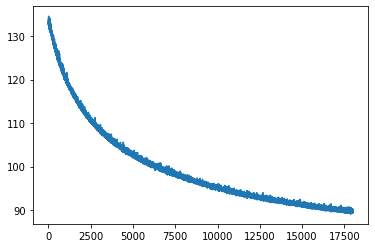

In [122]:
plt.plot(lvae.training_loss_list[2000:])

In [116]:
_,_,decoded = lvae.forward(Y)

In [119]:
torch.round(torch.exp(decoded))

tensor([[1., 1., 0.,  ..., 1., 1., 0.],
        [2., 2., 2.,  ..., 7., 5., 9.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        ...,
        [1., 2., 3.,  ..., 3., 2., 2.],
        [0., 1., 0.,  ..., 1., 2., 1.],
        [0., 2., 1.,  ..., 1., 0., 1.]], grad_fn=<RoundBackward0>)

In [118]:
Y

tensor([[1., 1., 0.,  ..., 2., 2., 0.],
        [2., 0., 3.,  ..., 5., 4., 9.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        ...,
        [4., 1., 5.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 2., 0., 1.]])

In [125]:
torch.mean(torch.abs(torch.round(torch.exp(decoded))-Y))

tensor(1.309, grad_fn=<MeanBackward0>)

In [126]:
torch.round(torch.exp(decoded))

tensor([[1., 1., 0.,  ..., 1., 1., 0.],
        [2., 2., 2.,  ..., 7., 5., 9.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        ...,
        [1., 2., 3.,  ..., 3., 2., 2.],
        [0., 1., 0.,  ..., 1., 2., 1.],
        [0., 2., 1.,  ..., 1., 0., 1.]], grad_fn=<RoundBackward0>)

In [135]:
n_ = 24
print(Y[0,n_])
print(torch.round(torch.exp(decoded))[0,n_])

tensor(57.)
tensor(67., grad_fn=<SelectBackward0>)


In [93]:
torch.round(torch.exp(decoded))-Y

tensor([[ 1., -1.,  2.,  ..., -2.,  0.,  0.],
        [ 0., -1.,  2.,  ...,  0., -2., -3.],
        [ 0.,  0.,  0.,  ...,  1.,  1.,  0.],
        ...,
        [-1.,  1.,  0.,  ..., -1., -1.,  1.],
        [ 1.,  1.,  0.,  ...,  1., -2.,  2.],
        [ 1.,  1., -1.,  ..., -2.,  1., -2.]], grad_fn=<SubBackward0>)

In [73]:
Y.argmax(axis = 0)

tensor([ 81, 138,  38,  13,  13, 101,  61,  44, 153, 153,   6,  97, 119,  99,
         97,   8,  12,  12, 182,  31, 112,  33,  74,  40,  41, 129,  35, 110,
         99, 106,   6,   6,   6,   6,   6, 133, 113, 137, 113,  59, 163, 101,
        165, 198,   8,  60, 178, 158,  62, 169])

In [88]:
Y[12,17]

tensor(15.)

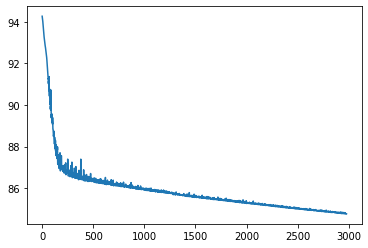

In [369]:
plt.plot(lvae.training_loss_list[20:])

lr :  1e-05
Epoch:1, Training loss:2658141862030159118336.0000
Epoch:2, Training loss:290.9557
Epoch:3, Training loss:107.9141
Epoch:4, Training loss:95.9855
Epoch:5, Training loss:94.2501
Epoch:6, Training loss:93.8206
Epoch:7, Training loss:93.5007
Epoch:8, Training loss:93.3955
Epoch:9, Training loss:93.3636
Epoch:10, Training loss:93.3517
Epoch:11, Training loss:93.3187
Epoch:12, Training loss:93.3048
Epoch:13, Training loss:93.2969
Epoch:14, Training loss:93.2927
Epoch:15, Training loss:93.2910
Epoch:16, Training loss:93.2891
Epoch:17, Training loss:93.2883
Epoch:18, Training loss:93.2877
Epoch:19, Training loss:93.2874
Epoch:20, Training loss:93.2870
Epoch:21, Training loss:93.2865
Epoch:22, Training loss:93.2862
Epoch:23, Training loss:93.2858
Epoch:24, Training loss:93.2854
Epoch:25, Training loss:93.2851
Epoch:26, Training loss:93.2847
Epoch:27, Training loss:93.2842
Epoch:28, Training loss:93.2838
Epoch:29, Training loss:93.2834
Epoch:30, Training loss:93.2830
Epoch:31, Train

Epoch:63, Training loss:nan
Epoch:64, Training loss:nan
Epoch:65, Training loss:nan
Epoch:66, Training loss:nan
Epoch:67, Training loss:nan
Epoch:68, Training loss:nan
Epoch:69, Training loss:nan
Epoch:70, Training loss:nan
Epoch:71, Training loss:nan
Epoch:72, Training loss:nan
Epoch:73, Training loss:nan
Epoch:74, Training loss:nan
Epoch:75, Training loss:nan
Epoch:76, Training loss:nan
Epoch:77, Training loss:nan
Epoch:78, Training loss:nan
Epoch:79, Training loss:nan
Epoch:80, Training loss:nan
Epoch:81, Training loss:nan
Epoch:82, Training loss:nan
Epoch:83, Training loss:nan
Epoch:84, Training loss:nan
Epoch:85, Training loss:nan
Epoch:86, Training loss:nan
Epoch:87, Training loss:nan
Epoch:88, Training loss:nan
Epoch:89, Training loss:nan
Epoch:90, Training loss:nan
Epoch:91, Training loss:nan
Epoch:92, Training loss:nan
Epoch:93, Training loss:nan
Epoch:94, Training loss:nan
Epoch:95, Training loss:nan
Epoch:96, Training loss:nan
Epoch:97, Training loss:nan
Epoch:98, Training l

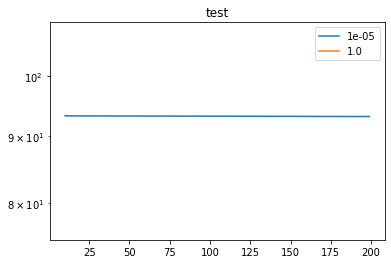

In [399]:
optim = torch.optim.Adamax

lr_list = np.logspace(-5,0,2)
def plot_lr(optimizer, lr_list, nb_iter, name = 'test'):
    list_training_loss = list()
    for lr in lr_list: 
        print('lr : ', lr )
        lvae = PLN_encoder(p,q)
        lvae._train(Y,O,covariates, nb_iter, batch_size = 15 ,optimizer = optim, lr = lr, lr_model = 0.01)
        list_training_loss.append(lvae.training_loss_list)
        
    length = len(list_training_loss[0])

    for i, lr in enumerate(lr_list)  : 
        plt.plot(np.arange(length)[10:] , list_training_loss[i][10:], label = str(lr))

    plt.legend()
    plt.ylim([75,110])
    plt.yscale('log')
    plt.title(name)
    plt.savefig(name)

    plt.show()
    return list_training_loss
        
list_training_loss = plot_lr(optim, lr_list, 200)
    

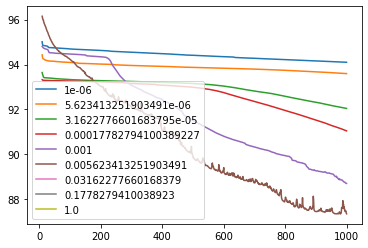

In [373]:
length = len(list_training_loss[0])

for i, lr in enumerate(lr_list)  : 
    plt.plot(np.arange(length)[10:] , list_training_loss[i][10:], label = str(lr))
    
plt.legend()
plt.savefig(name)
plt.show()

lr :  1e-05
Training finished
lr :  6.812920690579608e-05
Training finished
lr :  0.0004641588833612782
Training finished
lr :  0.0031622776601683794
Training finished
lr :  0.021544346900318846
Training finished
lr :  0.14677992676220705
Training finished
lr :  1.0
Training finished


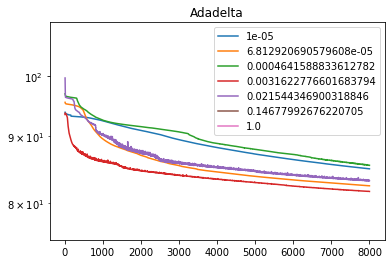

lr :  1e-05
Training finished
lr :  6.812920690579608e-05
Training finished
lr :  0.0004641588833612782
Training finished
lr :  0.0031622776601683794


KeyboardInterrupt: 

In [405]:
def try_optim(dict_optim, lr_list): 
    list_res = list()
    for name, optim in dict_optim.items(): 
        res = plot_lr(optim, lr_list,8000, name = name)
        list_res.append(res)
    return list_res
        
lr_list = np.logspace(-5,0,7)
list_res = try_optim(dict_optim, lr_list)
    

In [ ]:
def try_future_optim(dict_optim, lr_list):
    list_res = list()
    for t in ts : 
        t.join()

In [ ]:
def plot_threading_lr(optim, lr_list, nb_iter):     
    list_training_loss = list()
    for lr in lr_list: 
        lvae = PLN_encoder(p,q)
        t = threading.Thread(target =lvae._train,
              args = [Y,O,covariates, nb_iter, 15 , optim, torch.optim.Rprop, lr, 0.01, False])
        list_training_loss.append(lvae.training_loss_list)
        
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
        
        
    for lr in lr_list: 
        print('lr : ', lr )
        lvae = PLN_enocder(p,q)
        lvae._train(Y,O,covariates, nb_iter, batch_size = 15 ,optimizer = optim, lr = lr, lr_model = 0.01)
        list_training_loss.append(lvae.training_loss_list)
        
    length = len(list_training_loss[0])

    for i, lr in enumerate(lr_list)  : 
        plt.plot(np.arange(length)[10:] , list_training_loss[i][10:], label = str(lr))

    plt.legend()
    plt.ylim([75,110])
    plt.yscale('log')
    plt.title(name)
    plt.savefig(name)

    plt.show()

In [396]:
dict_optim = {'Adadelta': torch.optim.Adadelta, 'Adagrad': torch.optim.Adagrad, 
             'Adam': torch.optim.Adam,'Adamax': torch.optim.Adamax,'adamW': torch.optim.AdamW,
              'ASGD': torch.optim.ASGD,'LBFGS': torch.optim.LBFGS
             ,'NAdam': torch.optim.NAdam,'RAdam': torch.optim.RAdam,
              'RMSprop': torch.optim.RMSprop,'Rprop': torch.optim.Rprop,'SGD': torch.optim.SGD,
              'SparseAdam' :torch.optim.SparseAdam, 
               'swa_utils': torch.optim.swa_utils}

<AxesSubplot:>

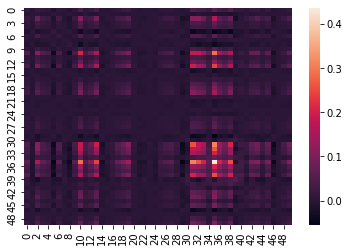

In [36]:
sns.heatmap((lvae.C@(lvae.C.T)).detach())

<AxesSubplot:>

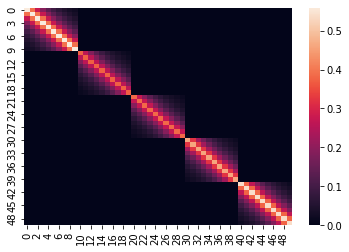

In [116]:
sns.heatmap(Sigma_sampling)

In [223]:
true_beta

tensor([[ 0.064, -0.397, -0.873,  0.158, -0.723,  0.201,  0.560, -0.023, -0.044,
          0.277,  0.036,  0.946, -0.492,  0.522, -0.925, -1.489,  0.554,  0.301,
         -0.830,  1.673, -0.473, -0.289,  1.078,  0.134,  0.236, -0.989,  0.088,
          0.017,  1.008, -0.490, -0.681,  0.825,  0.046, -0.142,  0.093, -0.269,
          0.574,  0.278, -0.111, -0.266,  0.594,  0.398,  1.303, -0.834,  0.335,
         -0.355, -0.147,  0.139,  1.621, -0.060],
        [ 0.370,  0.268, -0.047, -0.593,  0.188, -0.157, -0.636,  1.797, -0.120,
         -0.178,  0.101, -0.822,  0.723, -0.292,  0.979, -0.017,  0.496, -0.649,
         -0.886,  0.266, -0.708,  0.751, -0.134,  1.159,  0.045, -0.231, -1.042,
         -0.820, -0.664,  0.529,  0.893, -0.314,  1.297,  0.318, -0.651,  0.933,
          0.573,  0.081, -0.884, -0.513, -0.101, -0.763, -0.407,  0.341, -0.641,
          0.014, -0.054, -0.048,  1.041, -0.167]])

In [224]:
lvae.beta

tensor([[ 0.080, -0.345, -0.881,  0.123, -0.785,  0.119,  0.476, -0.108, -0.062,
          0.202,  0.051,  1.105, -0.359,  0.507, -0.857, -1.460,  0.560,  0.341,
         -0.796,  1.654, -0.598, -0.154,  1.241,  0.134,  0.285, -0.973,  0.191,
          0.084,  1.210, -0.550, -0.552,  0.876,  0.270,  0.036,  0.041, -0.315,
          0.638,  0.317, -0.174, -0.300,  0.597,  0.443,  1.194, -0.853,  0.299,
         -0.453, -0.087,  0.179,  1.675, -0.249],
        [ 0.462,  0.513,  0.091, -0.462,  0.299, -0.113, -0.690,  1.878, -0.211,
         -0.104,  0.125, -0.635,  0.759, -0.371,  0.938,  0.032,  0.486, -0.646,
         -0.912,  0.297, -0.663,  0.762, -0.119,  1.249,  0.020, -0.270, -1.123,
         -0.847, -0.711,  0.547,  0.863, -0.242,  1.258,  0.325, -0.652,  0.938,
          0.591,  0.143, -0.825, -0.436, -0.029, -0.688, -0.441,  0.455, -0.619,
          0.151, -0.072, -0.078,  1.018, -0.187]], requires_grad=True)

In [244]:
lvae.beta

tensor([[ 0.081, -0.344, -0.881,  0.124, -0.786,  0.119,  0.477, -0.111, -0.062,
          0.202,  0.050,  1.104, -0.360,  0.506, -0.857, -1.460,  0.559,  0.340,
         -0.795,  1.654, -0.597, -0.154,  1.240,  0.134,  0.286, -0.969,  0.190,
          0.083,  1.208, -0.550, -0.551,  0.876,  0.270,  0.036,  0.039, -0.315,
          0.637,  0.316, -0.173, -0.301,  0.597,  0.445,  1.196, -0.854,  0.300,
         -0.451, -0.086,  0.179,  1.677, -0.248],
        [ 0.461,  0.512,  0.091, -0.461,  0.302, -0.112, -0.690,  1.879, -0.211,
         -0.104,  0.125, -0.637,  0.761, -0.373,  0.939,  0.030,  0.487, -0.647,
         -0.912,  0.298, -0.664,  0.761, -0.118,  1.248,  0.019, -0.272, -1.123,
         -0.848, -0.711,  0.548,  0.863, -0.242,  1.258,  0.326, -0.652,  0.940,
          0.591,  0.143, -0.827, -0.437, -0.029, -0.689, -0.441,  0.459, -0.618,
          0.151, -0.072, -0.078,  1.019, -0.188]], requires_grad=True)

In [262]:
fastpca = models.fastPLNPCA(q)

In [270]:
fastpca.fit(pd.DataFrame(Y),pd.DataFrame(O),pd.DataFrame(covariates), verbose = True, N_iter_max = 500)

Iteration number:  0
-------UPDATE-------
Delta :  1
Tolerance 0.001 reached in 15 iterations


Last ELBO : -76.81670597940432
Dimension of the latent space : 5


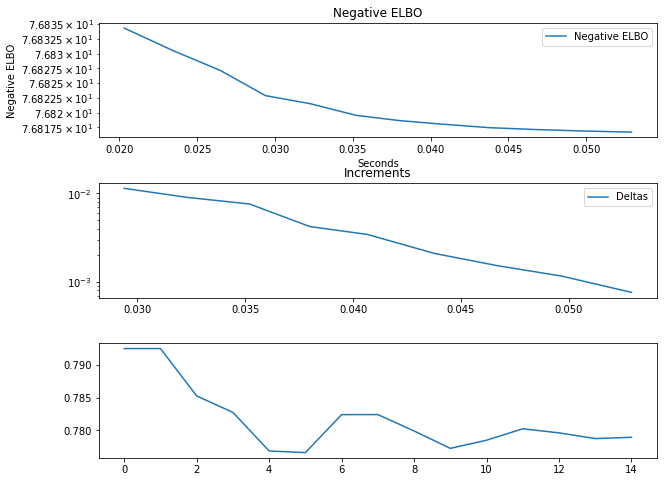

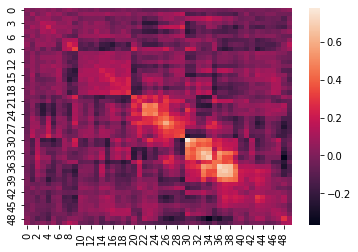

In [302]:
print(fastpca)

<AxesSubplot:>

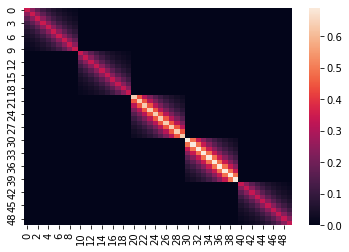

In [272]:
sns.heatmap(Sigma_sampling)

In [125]:
import PLNpy
from PLNpy import models
import pandas as pd

